# We are not providing you with any code for this assignment, so you must code everything yourself. However, we are providing you with an example notebook on how to run an MCMC.
# Furthermore, we provide a noise-free and noisy reference model from which you must derive parameters. Lastly, we give you three noisy covariance matrices.
# We recommend running the MCMC not in a Jupyter Notebook but instead using an external Python script.

In [2]:
# Import all of the necessary modules and functions
import matplotlib.pyplot as plt
import time
import random
import numpy as np
from numpy.linalg import inv
from cosmopower import cosmopower_NN
import emcee
from getdist import plots, MCSamples
from sklearn.decomposition import PCA

In [3]:
# This cell is for formatting plots, and can be commented out if it causes problems
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rcParams["font.size"] = 16
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"

First, we load in all of the reference models and covariance matrices that we'll need for the assignment.

In [5]:
cov=np.load('data_4_assignment3/covariance.npy') # load the analytic covariance matrix

minimum=np.load('data_4_assignment3/minimum.npy') # load the minimum model value for normalization
maximum=np.load('data_4_assignment3/maximum.npy') # load the maximum model value for normalization

models = np.load('data_4_assignment2/models.npy') # load the models that were used to train the emulator
reference_model = np.load('data_4_assignment3/reference_model.npy') # load the noiseless reference model for this analysis
reference_model_noisy = np.load('data_4_assignment3/reference_model_noise.npy') # load the noisy reference model for this analysis

cp_nn_model = cosmopower_NN(restore=True, restore_filename='data_4_assignment3/emulator_final') # load the emulator

cov_num_1500 = np.load('data_4_assignment3/cov_num_1500.npy') # load a numerical covariance matrix computed from 1500 samples
cov_num_3000 = np.load('data_4_assignment3/cov_num_3000.npy') # load a numerical covariance matrix computed from 3000 samples
cov_num_10000 = np.load('data_4_assignment3/cov_num_10000.npy') # load a numerical covariance matrix computed from 10000 samples

In [6]:
parameters = np.load('data_4_assignment2/parameters.npz') # load the parameters for the training models

# create a dictionary for the four model parameters
reference_params = {}
for name in parameters.keys():
    reference_params[name]=[]

Here, we set the number of walkers and number of steps per walker to be used by our MCMC chains. The choice of 50 walkers and 3000 steps were chosen because they generated fairly smooth distributions for the parameters, and any more would have taken impractically long to run. A small number of burning steps was chosen as the walkers did not seem to require much of the chain to be thrown out in order to generate reasonable constraints.

In [7]:
total_steps = 3000 # total number of steps for each walker
burning_steps = 100 # number of buring steps to remove
nwalkers = 50 # number of walkers that probe the parameter space

param_names_varying = ['omega_m', 'omega_b', 'As', 'w'] # paramters we want to vary
ndim = len(param_names_varying)
# print the maximum parameter ranges for reference
#for name in param_names_varying:
#    print(name,'\t',np.min(parameters[name]),'\t',np.max(parameters[name]))

## You can use any sampler you like to use for the following tasks. Also, you can use your own emulator. You must use the noisy reference model for the first three tasks. Check for each task that the posteriors and the $\chi^2$ distributions are as expected.
## Your tasks for this week are the following:

### 1. Run an MCMC where you vary all four parameters you have trained on your emulator.

First, we define functions based on the provided "assignment_MCMC.ipynb" script that are used to facilitate the MCMC. These functions randomly spawn our walkers, establish our flat prior range and compute the liklihood of a given set of parameters.

The function `start_position_lh_and_step_size` in the provided code spawns particles randomly anywhere in the range of parameters used to train the emulator. After using this same spawning range in preliminary runs, we saw that some walkers occasionally got caught in a "local minimum in the liklihood potential". This prevented them from putting reasonable constraints on the parameters by generating small peaks in the distribution far from the best fit parameter values. So, the distributions from these initial runs were used to estimate the parameter constraints, and the `start_position_lh_and_step_size` function was modified to only spawn walkers relatively near those values. This has since ensured that the walkers sample the relevant region of the parameter space, as will be seen in the posterior plots to follow.

Additionally, the function `start_position_lh_and_step_size` in the provided code takes a random seed as an argument. We are not concerned with reproducing specific spawn points or chains for this assignment, and we instead prefer different runs to give different results, particularly in Question 4. So, I chose to gerenate random seeds based on the CPU clock time to ensure randomness without the need for changing arguments.

In [8]:
# a function that distributes start postions inside the trained parameters
def start_position_lh_and_step_size():
    random.seed(time.perf_counter()) # select a random seed based on the clock time
    p0 = [] # array for starting positions
    # loop through each walker
    for i in range(nwalkers):
        random_starts = [] # starting position for this walker

        # set limits for the starting positions based on expected distributions from preliminary runs
        new_lim = {'omega_m':[0.3,0.4],'omega_b':[0.035,0.058],'As':[1.5e-9,2.5e-9],'w':[-1.3,-1.0]}
        # loop through each parameter that we vary
        for name in param_names_varying:
            # set the supper and lower bounds for the parameter starting position
            lower_edge = np.min(new_lim[name])
            upper_edge = np.max(new_lim[name])
            if(lower_edge<0):
                lower_edge = lower_edge * 0.99
            else:
                lower_edge = lower_edge * 1.01
            if(upper_edge>0):
                upper_edge = upper_edge * 0.99
            else:
                upper_edge = upper_edge * 1.01     
                
            random_starts.append(random.uniform(lower_edge,upper_edge)) # set the random parameter starting position
        
        p0.append(random_starts)
    
    return np.array(p0) # return the starting positions for all of the walkers


# function that computes our priors. Here we only allow the walker to be inside the training range. You can also define Gaussian priors. 
def cal_logprior(para_dict):

    # set a flat prior of 0
    lnprior = 0
    # if the walker is outside the emulator training range, set the prior to negative infinity
    for name in param_names_varying:
        if(para_dict[name]>np.max(parameters[name])):
            lnprior = -np.inf
        if(para_dict[name]<np.min(parameters[name])):
            lnprior = -np.inf
    
    return lnprior


# function that computes the likelihood
def calc_likelihood(para):
    
    params = reference_params # initialize an array for the parameters
    # loop through each of the parameters that we vary and record the current values
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    pred_vector = cp_nn_model.predictions_np(params)[0] # get the predicted vector from the trained emulator
    pred_vector = pred_vector*maximum+minimum # scale the normalized prediction
    
    delta = pred_vector - model # compute the difference between the reference model and the prediction vector
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv,delta)) # compute the likelihood

    lnprior = cal_logprior(para_dict=params) # get the prior for these values

    return likelihood+lnprior # return the liklihood plus the prior


model = reference_model_noisy # set our model for the following quesitons to the noisy reference model

Next, we define functions for plotting. The first is used to generate triangle plots of the posteriors, and the second plots the $\chi^2$ distributions from the MCMC log probabilities.

In [9]:
# a function that creates a triangle plot of the posteriors from MCMC samples
def plot_posteriors(samples,labels,title=False):
    # "samples" are the MCMC samples
    # "labels" are the names of the sample sets to be put in the legend
    # "title" is a flag for whether the mean values should be printed on the plot

    para_names = parameters.keys()
    param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

    para_priors = {}
    para_priors_low = {}
    para_priors_up = {}
    for name in para_names:
        para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
        para_priors_low[name] = np.min(parameters[name])
        para_priors_up[name] = np.max(parameters[name])

    samples_getdist = []
    for sample in samples:
        # get the distributions from the MCMC samples
        samples_getdist.append(MCSamples(samples=sample, names=param_names_latex, ranges=para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3}))

    g = plots.get_subplot_plotter(width_inch=12)
    g.settings.axis_marker_lw = 1.0
    g.settings.axis_marker_ls = '-'
    g.settings.title_limit_labels = False
    g.settings.axis_marker_color = 'k'
    g.settings.legend_colored_text = True
    g.settings.figure_legend_frame = False
    g.settings.linewidth = 2.0
    g.settings.linewidth_contour = 3.0
    g.settings.legend_fontsize = 22
    g.settings.axes_fontsize = 17
    g.settings.axes_labelsize = 22
    g.settings.axis_tick_x_rotation = 45
    g.settings.axis_tick_max_labels = 6
    g.settings.solid_colors = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

    if title:
        g.triangle_plot(
            roots=samples_getdist,
            filled=True,
            legend_loc='upper right',
            legend_labels = labels,
            markers=reference_params,
            title_limit=1
        )
    else:
        g.triangle_plot(
            roots=samples_getdist,
            filled=True,
            legend_loc='upper right',
            legend_labels = labels,
            markers=reference_params
        )


# a function that plots a chi^2 distribution from the MCMC log probabilities
def plot_chi2(log_prob_samples, labels):
    # "log_prob_samples" are the MCMC log probabilities
    # "labels" are the names of the sample sets to be put in the legend 

    chi2=-2*log_prob_samples # compute the chi^2 distribution

    colours = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']
    for i in range(len(log_prob_samples)):
        chi2=-2*log_prob_samples[i]
        plt.hist(chi2,bins=100,density=True, label=labels[i],color=colours[i],alpha=0.4)
    plt.xlabel('$\chi^2$')
    plt.ylabel('Probability')
    plt.legend(loc='upper right')

Now, we run an MCMC using the Python package `emcee`. We inverting the given analytic covariance matrix, then we spawn the particles, run the chain, and save the resulting samples and log probabilities.

In [10]:
# MCMC with the analytic covariance matrix

cov_inv = inv(cov)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_covTrue = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_covTrue',samples_covTrue)
log_prob_samples_covTrue = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_covTrue',log_prob_samples_covTrue)

100%|██████████| 3000/3000 [14:26<00:00,  3.46it/s]


In [11]:
# load in the MCMC samples and log probabilities for the analytic covariance matrix from saved files

#samples_covTrue = np.load('data_4_assignment3/outputs_MCMC/MCMC_covTrue.npy')
#log_prob_samples_covTrue = np.load('data_4_assignment3/outputs_MCMC/logp_covTrue.npy')

Finally, we plot the posteriors for the four model parameters that we vary, as well as the $\chi^2$ distribution.

Removed no burn in


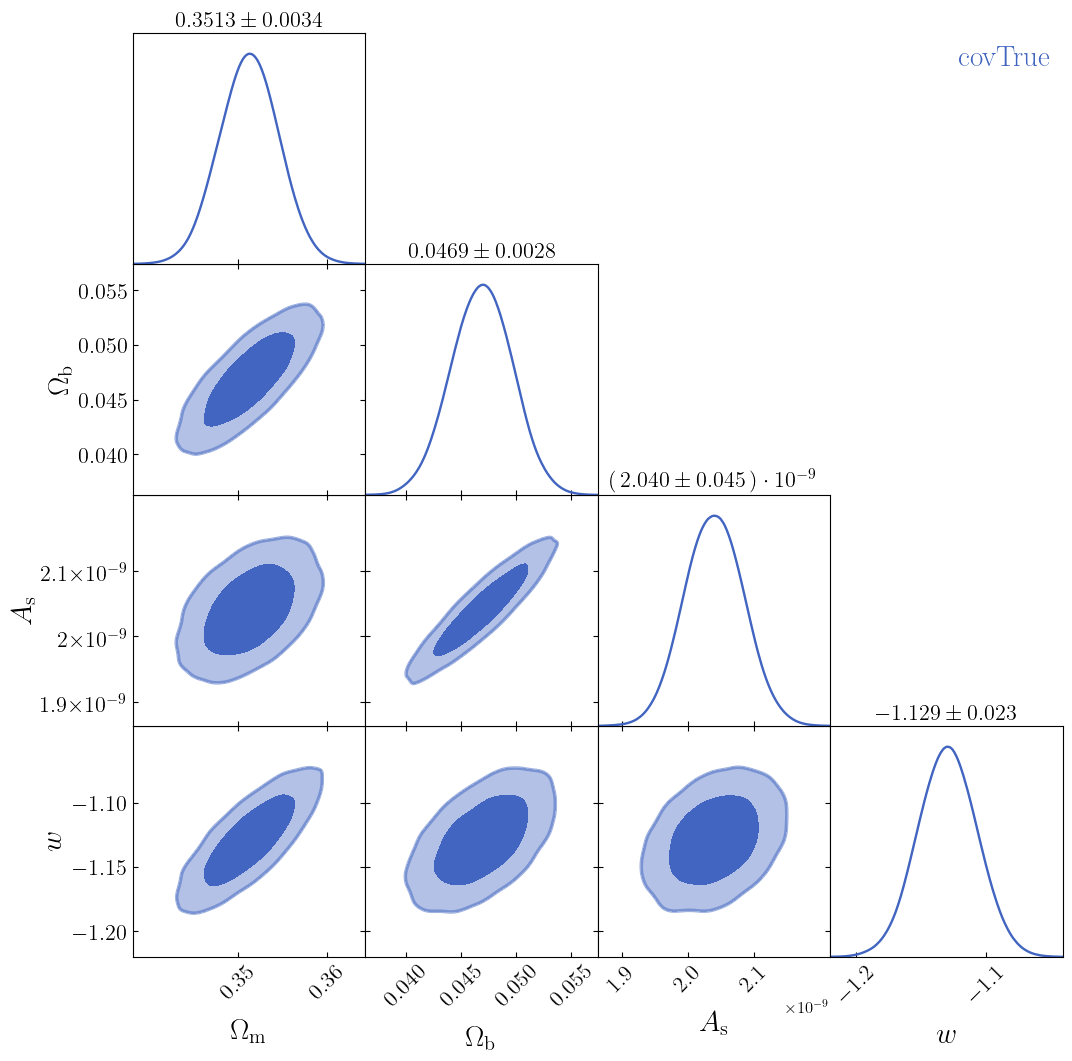

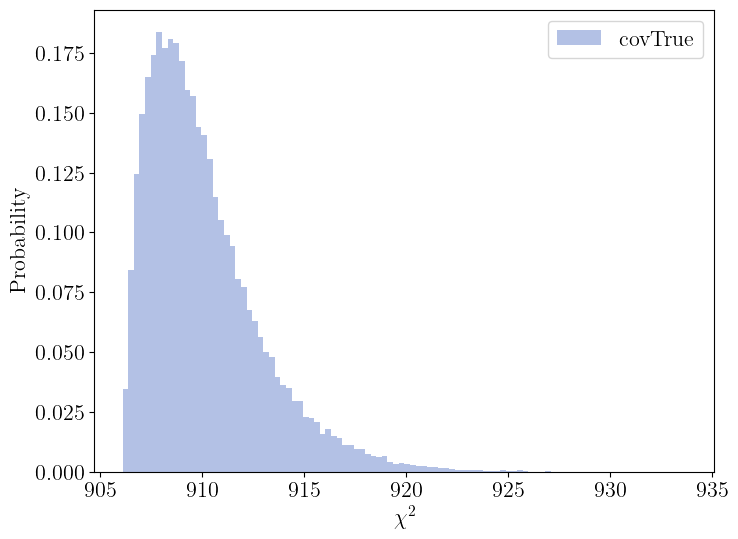

In [12]:
# plots for the analytic covariance matrix

plot_posteriors([samples_covTrue],
                labels=['covTrue'],title=True)
plt.savefig('data_4_assignment3/plots/covTrue_posteriors.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plot_chi2([log_prob_samples_covTrue],
          labels=['covTrue'])
plt.savefig('data_4_assignment3/plots/covTrue_chi2.jpg',dpi=600, bbox_inches='tight')
plt.show()

We see in the above plots that the posteriors generated from the MCMC give Gaussian distributions for each of the parameters, and smooth contours in each space, as expected. The constraints are each much less than 10% of the total values, giving good constraints. The $\chi^2$ distribution peaks above 905, which is slightly higher than we might expect. The model vector has 900 points and thus 900 degrees of freedom, so we wouldn't expect more than 900 for the peak of our $\chi^2$ distribution if we have a good fit, as we saw in Assignment 1. This indicates that the MCMC sampling exhibits some behaviour that is different from sampling from the covariance matrix as we did in previous assignments. The MCMC itself seems to introduce effective degrees of freedom, perhaps related to the four parameters that we're varying. This will be explored further in Question 4.

### 2. Use the provided numerical covariance matrices with [1.5k,3k,10k] data vectors as in assignment one. Run an MCMC for all of them with and without Hartlap correction, and compare with your results. Link your results to assignment one.

In the following three cells, we run MCMCs for the three specified covariance matrices without applying the Hartlap correction. In the next three, we do the same with the Hartlap correction applied to the inverse covariance matrices.

In [13]:
# MCMC with the numerical covariance matrix from 1500 vectors

cov_inv = inv(cov_num_1500)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov1500 = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov1500',samples_cov1500)
log_prob_samples_cov1500 = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov1500',log_prob_samples_cov1500)

100%|██████████| 3000/3000 [14:03<00:00,  3.56it/s]


In [14]:
# MCMC with the numerical covariance matrix from 1500 vectors with the Hartlap factor

n_r = int(1500)
n_d = len(cov_num_1500)
h = (n_r-1)/(n_r-n_d-2)
cov_inv = inv(cov_num_1500)/h

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov1500_hart = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov1500_hart',samples_cov1500_hart)
log_prob_samples_cov1500_hart = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov1500_hart',log_prob_samples_cov1500_hart)

100%|██████████| 3000/3000 [13:47<00:00,  3.63it/s]


In [15]:
# MCMC with the numerical covariance matrix from 3000 vectors

cov_inv = inv(cov_num_3000)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov3000 = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov3000',samples_cov3000)
log_prob_samples_cov3000 = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov3000',log_prob_samples_cov3000)

100%|██████████| 3000/3000 [14:43<00:00,  3.40it/s]


In [16]:
# MCMC with the numerical covariance matrix from 3000 vectors with the Hartlap factor

n_r = int(3000)
n_d = len(cov_num_3000)
h = (n_r-1)/(n_r-n_d-2)
cov_inv = inv(cov_num_3000)/h

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov3000_hart = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov3000_hart',samples_cov3000_hart)
log_prob_samples_cov3000_hart = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov3000_hart',log_prob_samples_cov3000_hart)

100%|██████████| 3000/3000 [26:04<00:00,  1.92it/s]


In [17]:
# MCMC with the numerical covariance matrix from 10000 vectors

cov_inv = inv(cov_num_10000)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov10000 = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov10000',samples_cov10000)
log_prob_samples_cov10000 = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov10000',log_prob_samples_cov10000)

100%|██████████| 3000/3000 [27:39<00:00,  1.81it/s]


In [18]:
# MCMC with the numerical covariance matrix from 10000 vectors with the Hartlap factor

n_r = int(10000)
n_d = len(cov_num_10000)
h = (n_r-1)/(n_r-n_d-2)
cov_inv = inv(cov_num_10000)/h

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov10000_hart = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov10000_hart',samples_cov10000_hart)
log_prob_samples_cov10000_hart = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov10000_hart',log_prob_samples_cov10000_hart)

100%|██████████| 3000/3000 [28:34<00:00,  1.75it/s]


In [19]:
# load in the MCMC samples and log probabilities for the various numberical covariance matricies,
# with and without the Hartlap correction, from saved files

#samples_cov1500 = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov1500.npy')
#samples_cov3000 = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov3000.npy')
#samples_cov10000 = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov10000.npy')
#samples_cov1500_hart = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov1500_hart.npy')
#samples_cov3000_hart = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov3000_hart.npy')
#samples_cov10000_hart = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov10000_hart.npy')
#
#log_prob_samples_cov1500 = np.load('data_4_assignment3/outputs_MCMC/logp_cov1500.npy')
#log_prob_samples_cov3000 = np.load('data_4_assignment3/outputs_MCMC/logp_cov3000.npy')
#log_prob_samples_cov10000 = np.load('data_4_assignment3/outputs_MCMC/logp_cov10000.npy')
#log_prob_samples_cov1500_hart = np.load('data_4_assignment3/outputs_MCMC/logp_cov1500_hart.npy')
#log_prob_samples_cov3000_hart = np.load('data_4_assignment3/outputs_MCMC/logp_cov3000_hart.npy')
#log_prob_samples_cov10000_hart = np.load('data_4_assignment3/outputs_MCMC/logp_cov10000_hart.npy')

Here, we plot the posteriors and $\chi^2$ distributions from the MCMCs for each of the covariance matrices without the Hartlap correction.

Removed no burn in
Removed no burn in
Removed no burn in


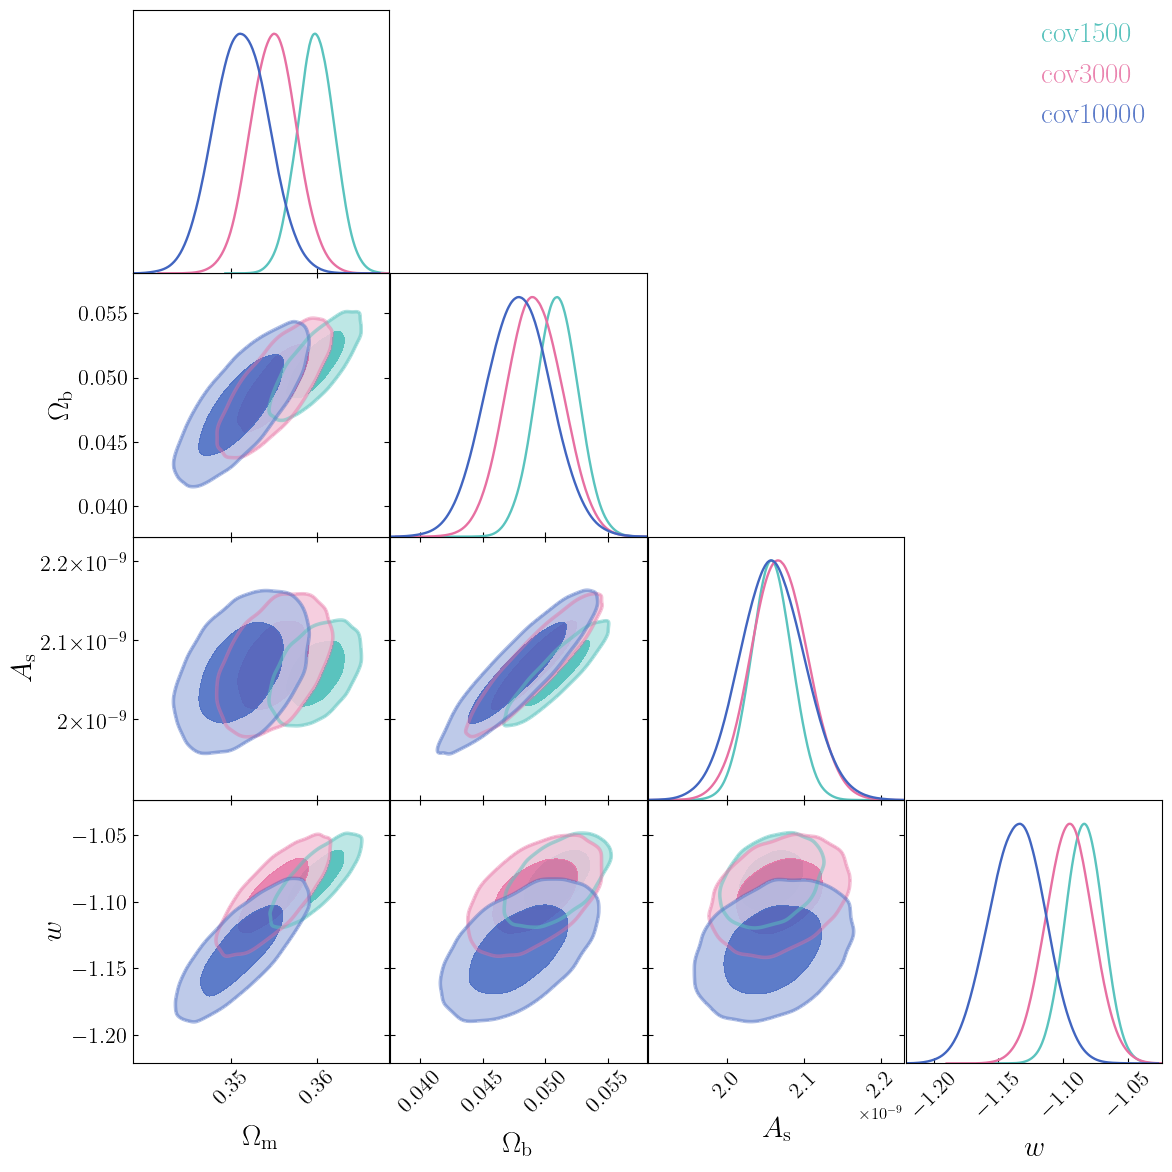

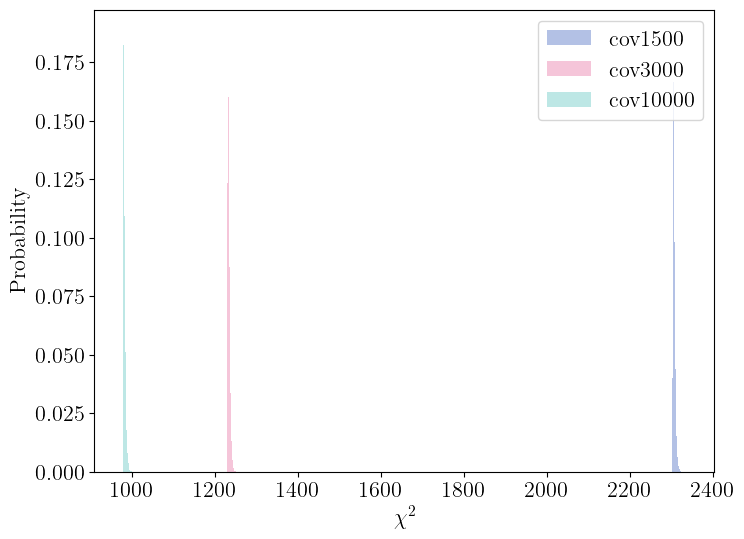

In [20]:
# plots for the three numerical covariance matricies

plot_posteriors([samples_cov1500, samples_cov3000, samples_cov10000],
                labels=['cov1500','cov3000','cov10000'])
plt.savefig('data_4_assignment3/plots/covNum_noHart_posteriors.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plot_chi2([log_prob_samples_cov1500,log_prob_samples_cov3000,log_prob_samples_cov10000],
           labels=['cov1500','cov3000','cov10000'])
plt.savefig('data_4_assignment3/plots/covNum_noHart_chi2.jpg',dpi=600, bbox_inches='tight')
plt.show()

Next, we plot the posteriors and $\chi^2$ distributions from the MCMCs for each of the covariance matrices with the Hartlap correction.

Removed no burn in
Removed no burn in
Removed no burn in


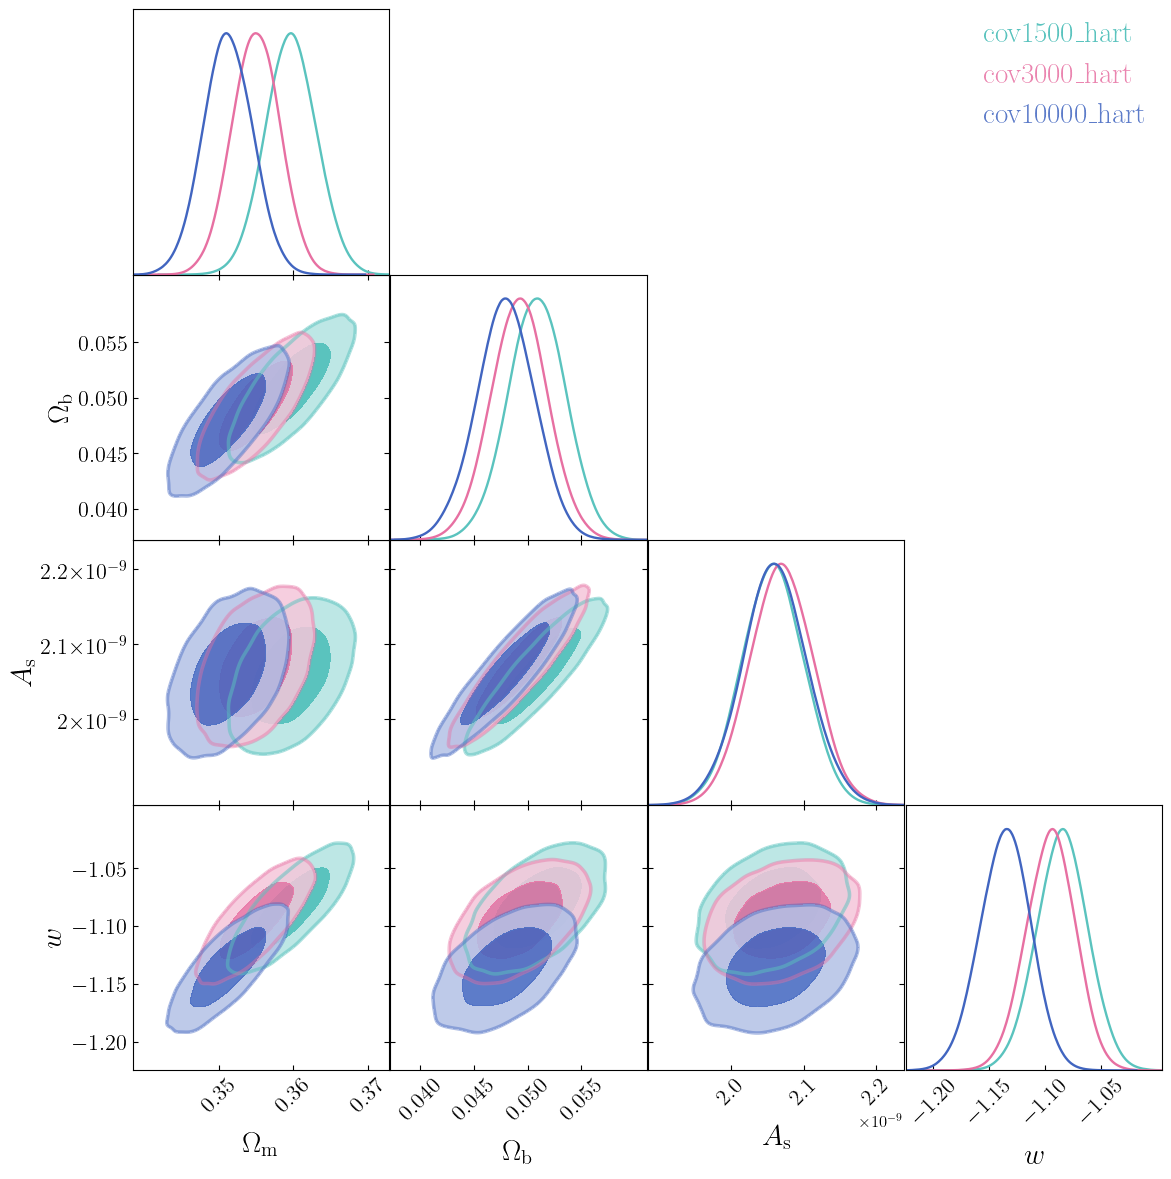

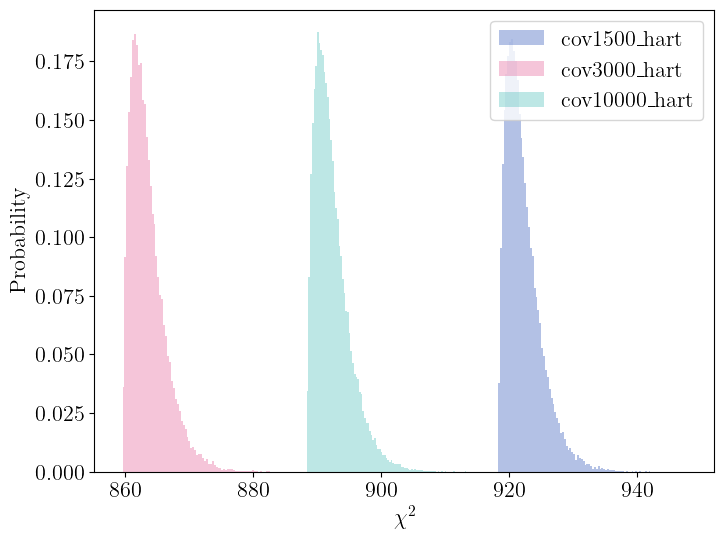

In [21]:
# plots for the three numerical covariance matricies with the Hartlap factor

plot_posteriors([samples_cov1500_hart, samples_cov3000_hart, samples_cov10000_hart],
                labels=['cov1500_hart','cov3000_hart','cov10000_hart'])
plt.savefig('data_4_assignment3/plots/covNum_hart_posteriors.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plot_chi2([log_prob_samples_cov1500_hart,log_prob_samples_cov3000_hart,log_prob_samples_cov10000_hart],
           labels=['cov1500_hart','cov3000_hart','cov10000_hart'])
plt.savefig('data_4_assignment3/plots/covNum_hart_chi2.jpg',dpi=600, bbox_inches='tight')
plt.show()

We see in the above sets of plots that without the Hartlap correction that the covariance matrices generated from fewer model vectors have tighter constraints than those generated from more model vectors. This is expected because covariance matrices computed from fewer samples are noisier, and thus give tighter constraints if they are not corrected by the Hartlap factor, as we saw in Assignment 1. We see also that the $\chi^2$ distributions without the Harlap factor are much greater than 900 for covariance matrices generated from fewer vectors.

With the Hartlap correction, we see above that the contraints on the parameters are equally strong for each covariance matrix. However, the mean values do shift for different covariance matrices. This suggests that matrices generated from too few vectors do not give accurate results compared to the analytic matrix. The $\chi^2$ distributions in this case are all around 900 as expected. However, it's strange that the matrix generated from 3000 elements has the lowest $\chi^2$, while that from 1500 elements has the greatest. This further supports the observation that the $\chi^2$ distributions generated from MCMC sampling are quite different from those seen previously in Assignment 1.

Now, we'll plot the posteriors and $\chi^2$ distributions for each of the covariance matrices separately, with and without the Hartlap correction, so that we can compare the effect of the correction on the results from each matrix.

Removed no burn in
Removed no burn in


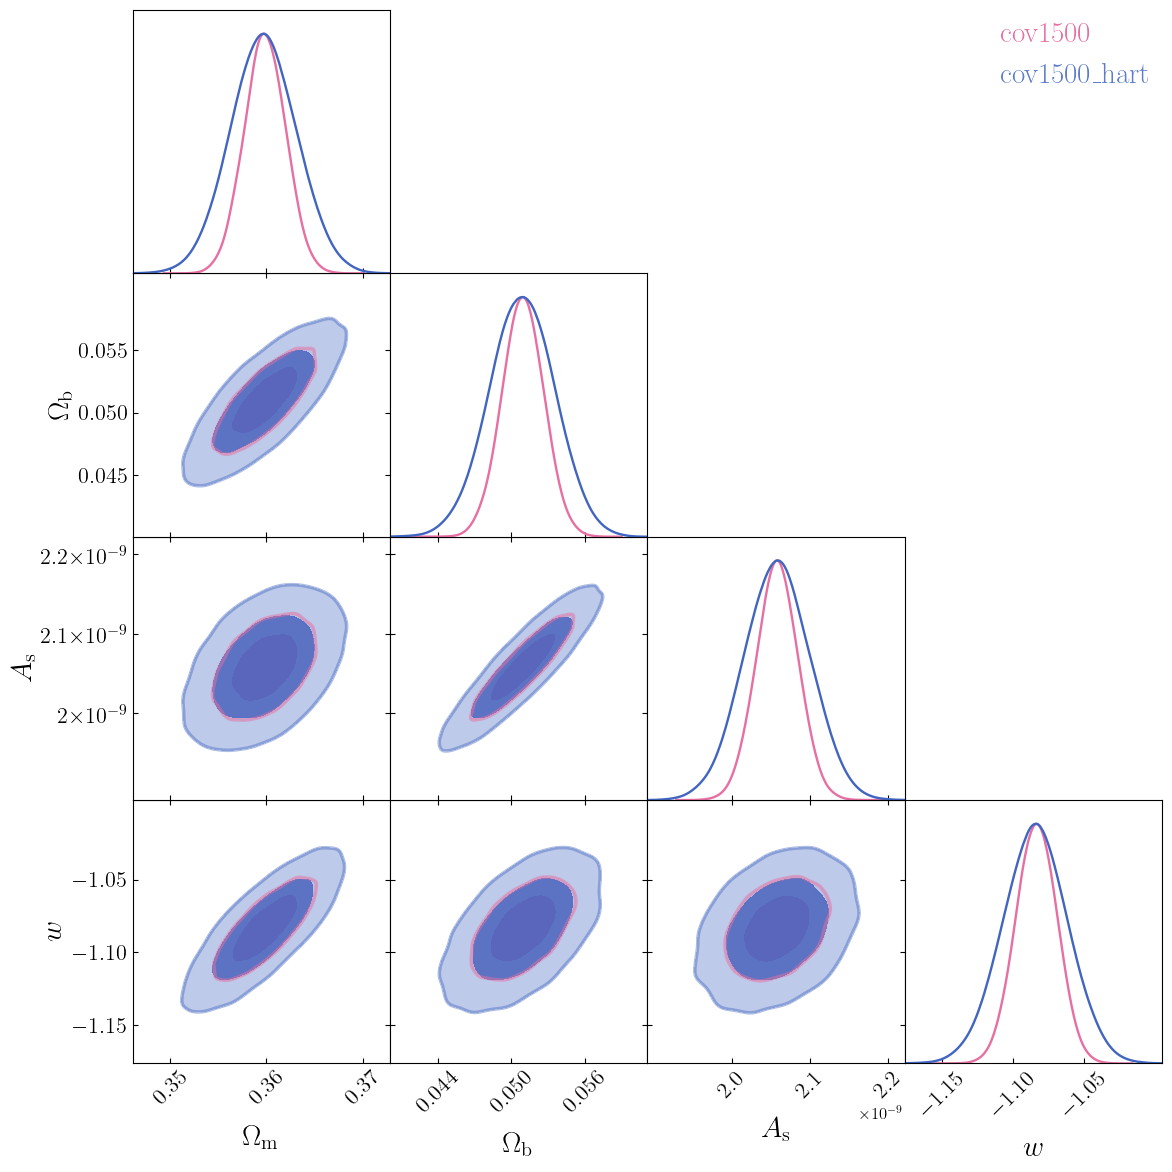

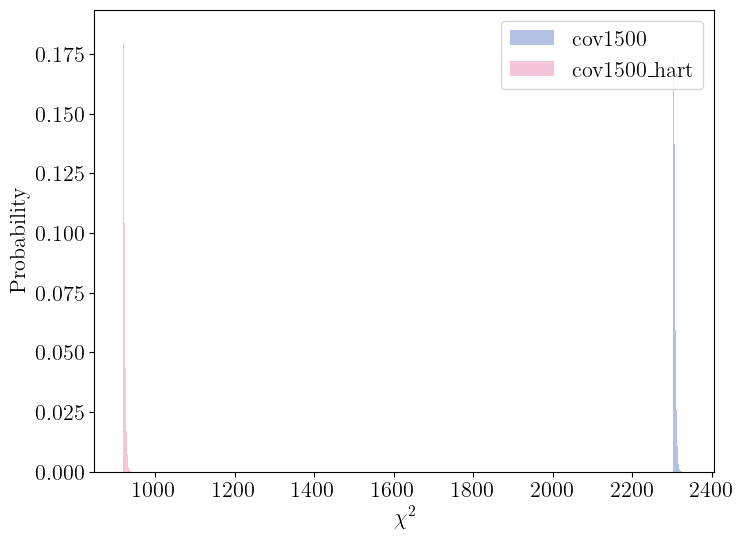

In [22]:
# plots for the numerical covariance matrix from 1500 vectors with and without the Hartlap factor

plot_posteriors([samples_cov1500, samples_cov1500_hart],
                labels=['cov1500','cov1500_hart'])
plt.savefig('data_4_assignment3/plots/cov1500_posteriors.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plot_chi2([log_prob_samples_cov1500,log_prob_samples_cov1500_hart],
           labels=['cov1500','cov1500_hart'])
plt.savefig('data_4_assignment3/plots/cov1500_chi2.jpg',dpi=600, bbox_inches='tight')
plt.show()

Removed no burn in
Removed no burn in


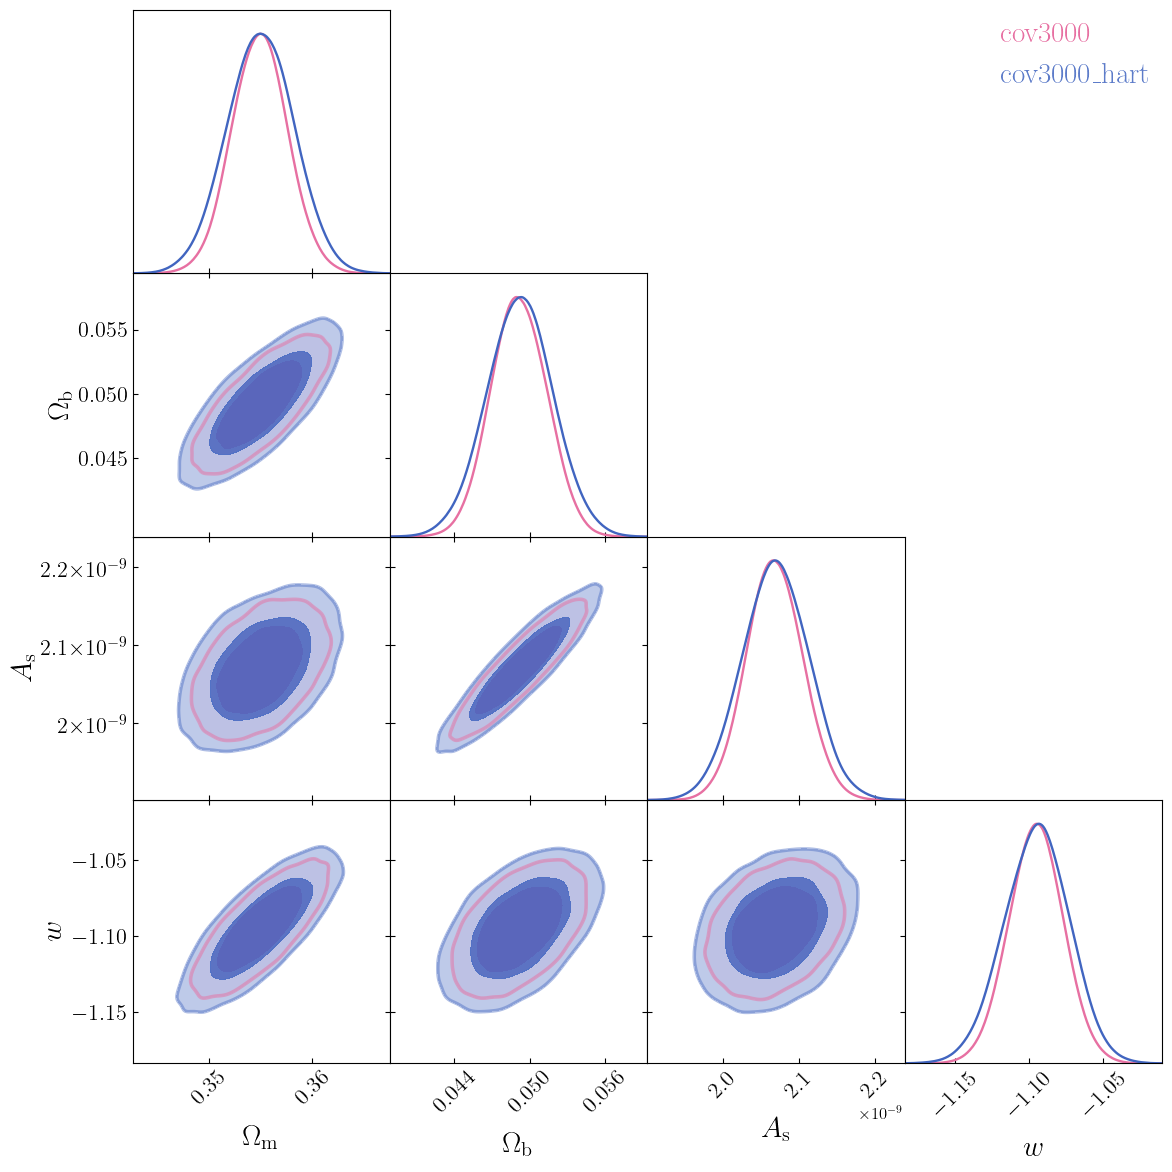

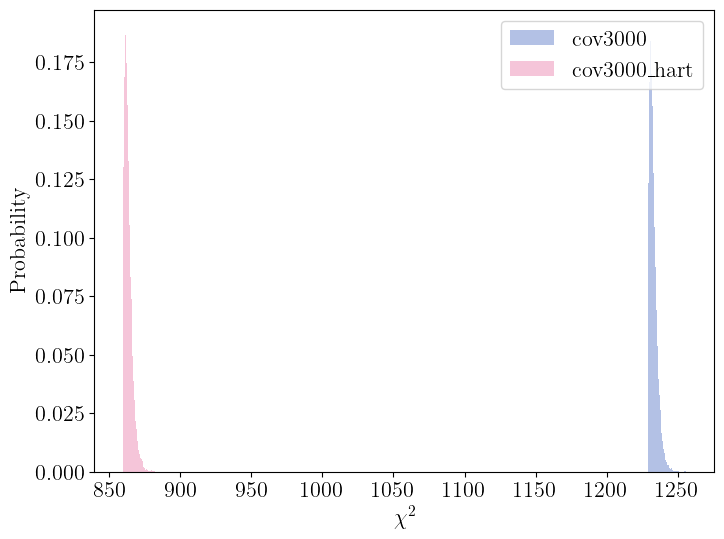

In [23]:
# plots for the numerical covariance matrix from 3000 vectors with and without the Hartlap factor

plot_posteriors([samples_cov3000, samples_cov3000_hart],
                labels=['cov3000','cov3000_hart'])
plt.savefig('data_4_assignment3/plots/cov3000_posteriors.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plot_chi2([log_prob_samples_cov3000,log_prob_samples_cov3000_hart],
           labels=['cov3000','cov3000_hart'])
plt.savefig('data_4_assignment3/plots/cov3000_chi2.jpg',dpi=600, bbox_inches='tight')
plt.show()

Removed no burn in
Removed no burn in


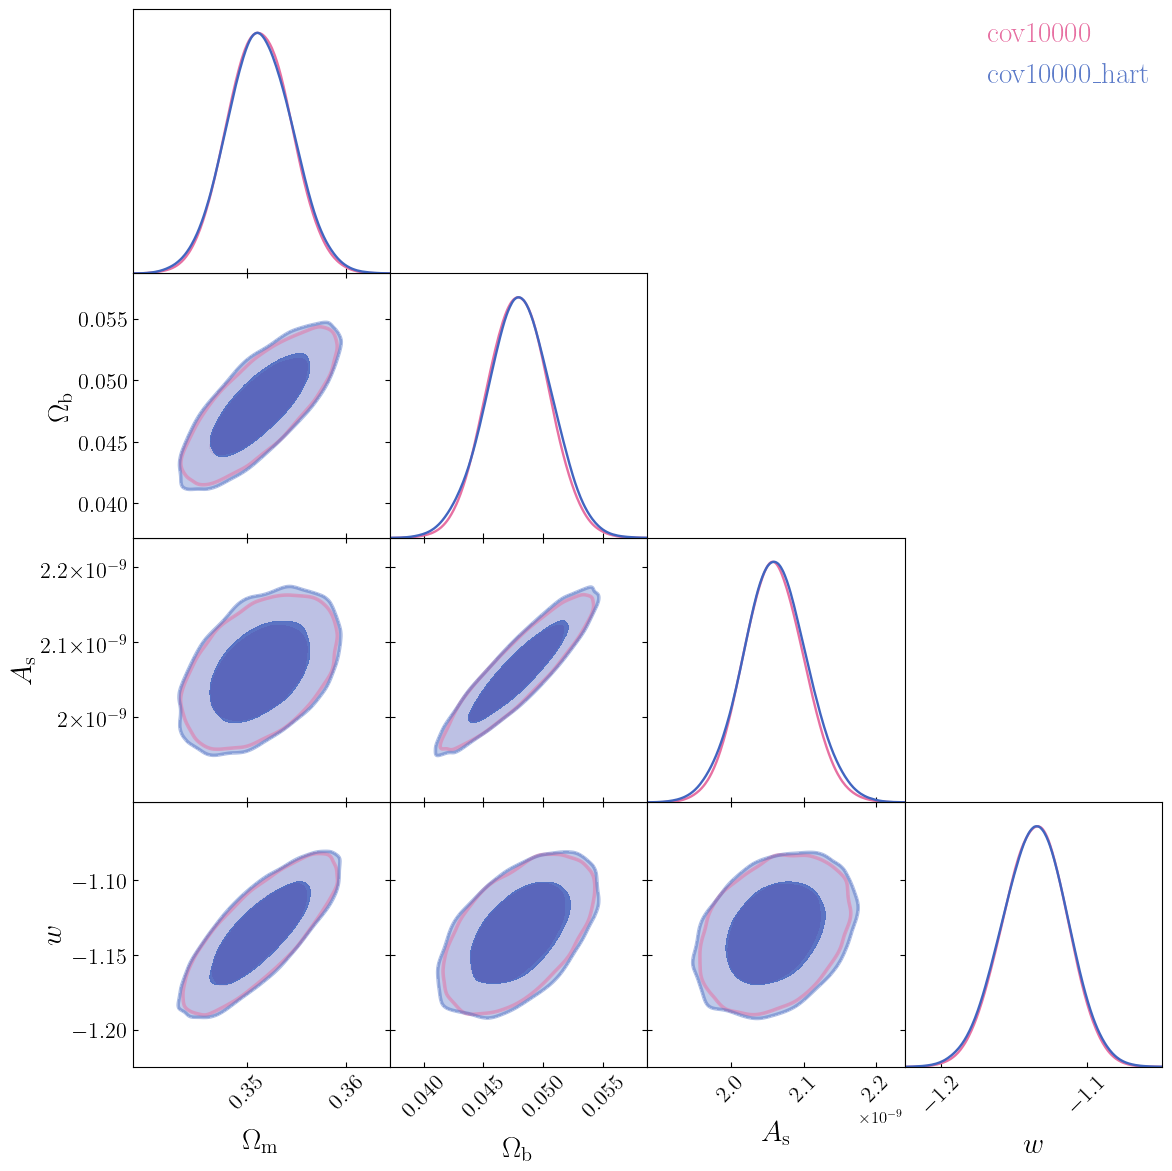

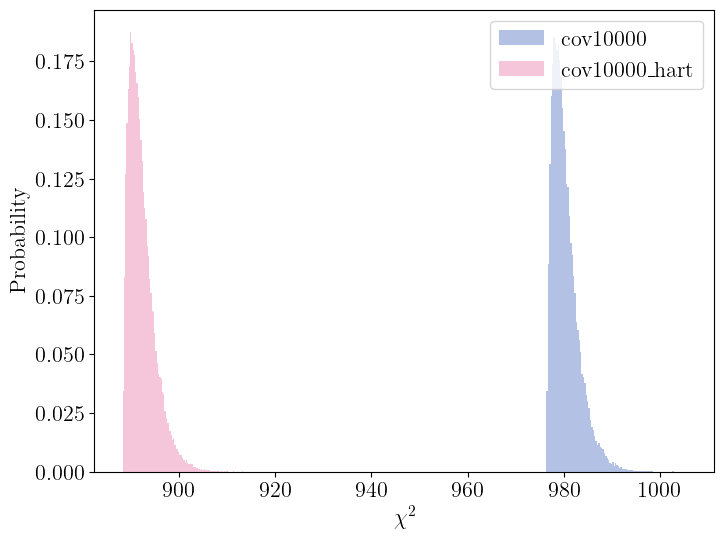

In [24]:
# plots for the numerical covariance matrix from 10000 vectors with and without the Hartlap factor

plot_posteriors([samples_cov10000, samples_cov10000_hart],
                labels=['cov10000','cov10000_hart'])
plt.savefig('data_4_assignment3/plots/cov10000_posteriors.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plot_chi2([log_prob_samples_cov10000,log_prob_samples_cov10000_hart],
           labels=['cov10000','cov10000_hart'])
plt.savefig('data_4_assignment3/plots/cov10000_chi2.jpg',dpi=600, bbox_inches='tight')
plt.show()

In the above posterior plots, we see that the Hartlap factor applies a larger correction to the constraints derived using covariance matrices generated from fewer models. This is expected, as those covariance matrices are noisier due to being generated from less data. We see that the posteriors for the covariance generated from 10000 data vectors are not significantly affected by the Hartlap factor, while those for the 3000 and 1500 covariance matrices are.

All of the $\chi^2$ distributions are affected significantly by the Hartlap factor. The more realistations used to generate the covariance matrix, the smaller this effect. However, it is still significant for the 10000 matrix. This is consistent with what we saw in Assignment 1, where the $\chi^2$ distributions were shifted to lower values due to the Hartlap factor correction in all cases, more significantly for the more noisy covariance matrices.

### 3. Next, we consider PCA data compression. Run an MCMC for several numbers of PCA elements. Link your results to assignment two.

####    3.a. Use the analytical covariance matrix.

First, we define some new functions to facilitate the PCA compression. The first function below is analogous to that which computes the liklihood of a set of parameters that we had previously, except that it includes a PCA compression of the vectors before computing the liklihood. The second function fits a PCA object, transforms the reference model, rotates the covariance matrix, and applies the Hartlap factor if necessary based on the dimension of the matrix after the PCA reduction.

In [25]:
# function that computes the likelihood with a PCA transformation
def calc_likelihood_pca(para):
    
    params = reference_params # initialize an array for the parameters
    # loop through each of the parameters that we vary and record the current values
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    pred_vector = cp_nn_model.predictions_np(params)[0] # get the predicted vector from the trained emulator
    pred_vector = pred_vector*maximum+minimum # scale the normalized prediction
    pred_vector_pca = pca.transform([pred_vector-mean])[0] # transform the prediction vector using a fitted PCA
    
    delta = pred_vector_pca - model # compute the difference between the reference model and the prediction vector
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv,delta)) # compute the likelihood

    lnprior = cal_logprior(para_dict=params) # get the prior for these values

    return likelihood+lnprior # return the liklihood plus the prior


# a function that computes and returns a trained PCA, transformed reference model and rotated covariance matrix
def make_pca_parts(N_pca,covariance,reference,hart):
    # "N_pca" is the number of PCA eigenvalues to use
    # "covariance" is the covariance matrix to be rotated
    # "reference" is the reference model to be transformed
    # "hart" is a flag for whether to scale by the Hartlap factor

    pca = PCA(n_components=N_pca,svd_solver='full') # initialize a PCA class
    pca.fit(models-mean) # perform the PCA fitting

    rotation_matrix = pca.components_.T # create a rotation matrix from the PCA fit
    cov_pca = rotation_matrix.T @ covariance @ rotation_matrix # rotate covariance matrix

    reference_pca = pca.transform([reference-mean])[0] # transform the reference model minus the mean using the fitted PCA
    cov_inv = inv(cov_pca) # invert the rotated covariance matrix

    # if we're using the Hartlap factor, correct the inverse covariance matrix by it
    if hart:
        n_r = int(1500) # number of realisations used to make covariance matrix
        n_d = int(N_pca) # dimension of covariance matrix
        h = (n_r-1)/(n_r-n_d-2) # hartlap factor
        cov_inv /= h

    # return the fitted PCA, the tranformed reference model, and the rotated inverse covariance matrix
    return pca,reference_pca,cov_inv


# for numerical stability, compute the mean of each element from the model vectors to be subtracted off later
mean = np.mean(models,axis=0)

Here, we run the MCMC using PCA compression with 100, 300, 600 and 900 PCA elements, respectively. We chose a maximum of 900 PCA elements since the model vector is 900 elements long, so this should effectively result in no compression. This allowa us to compare the effects of different levels compression compared to an uncompressed result.

In [26]:
# MCMC with the analytic covariance matrix and 100 PCA elements

pca,model,cov_inv = make_pca_parts(100,cov,reference_model_noisy,False)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_covTrue_pca100 = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca100',samples_covTrue_pca100)
log_prob_samples_covTrue_pca100 = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_covTrue_pca100',log_prob_samples_covTrue_pca100)

100%|██████████| 3000/3000 [31:18<00:00,  1.60it/s]  


In [27]:
# MCMC with the analytic covariance matrix and 300 PCA elements

pca,model,cov_inv = make_pca_parts(300,cov,reference_model_noisy,False)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_covTrue_pca300 = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca300',samples_covTrue_pca300)
log_prob_samples_covTrue_pca300 = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_covTrue_pca300',log_prob_samples_covTrue_pca300)

100%|██████████| 3000/3000 [26:30<00:00,  1.89it/s]


In [28]:
# MCMC with the analytic covariance matrix and 600 PCA elements

pca,model,cov_inv = make_pca_parts(600,cov,reference_model_noisy,False)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_covTrue_pca600 = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca600',samples_covTrue_pca600)
log_prob_samples_covTrue_pca600 = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_covTrue_pca600',log_prob_samples_covTrue_pca600)

100%|██████████| 3000/3000 [14:44<00:00,  3.39it/s]


In [29]:
# MCMC with the analytic covariance matrix and 900 PCA elements

pca,model,cov_inv = make_pca_parts(900,cov,reference_model_noisy,False)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_covTrue_pca900 = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca900',samples_covTrue_pca900)
log_prob_samples_covTrue_pca900 = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_covTrue_pca900',log_prob_samples_covTrue_pca900)

100%|██████████| 3000/3000 [16:59<00:00,  2.94it/s]


In [30]:
# load in the MCMC samples and log probabilities for the analytic covariance matrix
# with various PCA elements numbers from saved files

#samples_covTrue_pca100 = np.load('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca100.npy')
#samples_covTrue_pca300 = np.load('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca300.npy')
#samples_covTrue_pca600 = np.load('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca600.npy')
#samples_covTrue_pca900 = np.load('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca900.npy')
#
#log_prob_samples_covTrue_pca100 = np.load('data_4_assignment3/outputs_MCMC/logp_covTrue_pca100.npy')
#log_prob_samples_covTrue_pca300 = np.load('data_4_assignment3/outputs_MCMC/logp_covTrue_pca300.npy')
#log_prob_samples_covTrue_pca600 = np.load('data_4_assignment3/outputs_MCMC/logp_covTrue_pca600.npy')
#log_prob_samples_covTrue_pca900 = np.load('data_4_assignment3/outputs_MCMC/logp_covTrue_pca900.npy')

Here, we plot the posteriors and $\chi^2$ distributions for each number of PCA elements to compare the results.

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


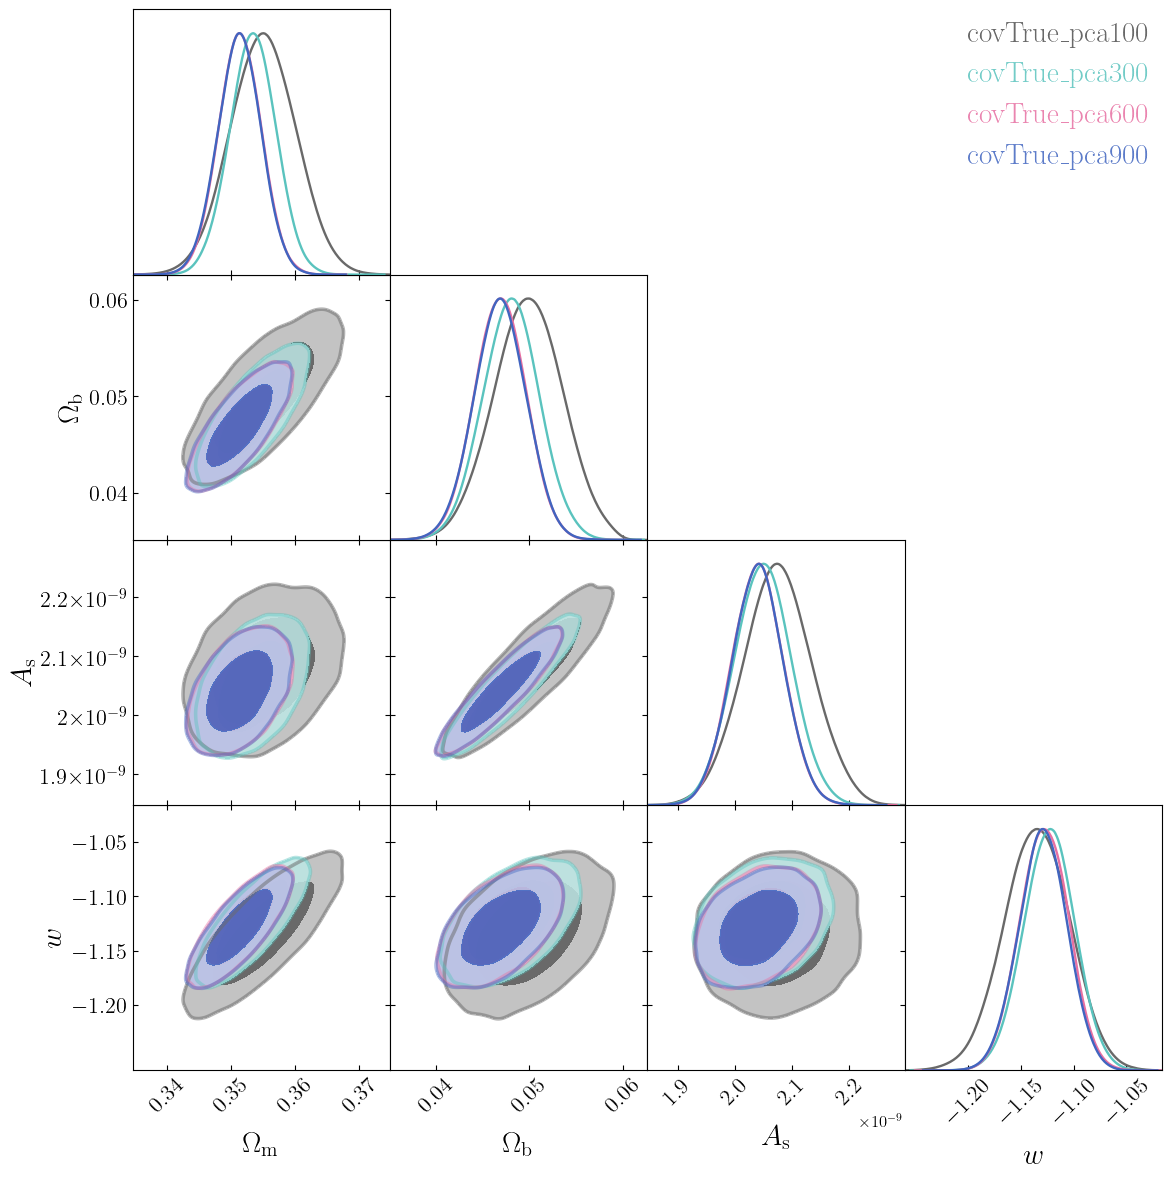

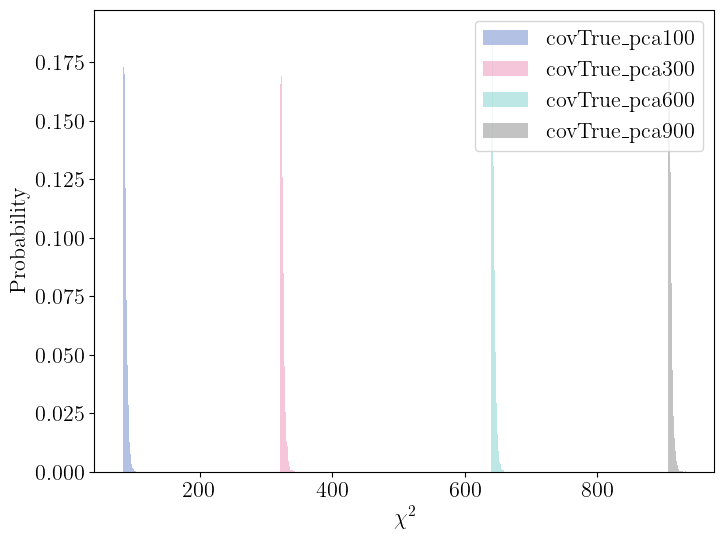

In [31]:
# plots for the analytic covariance matrix with 100, 300, 600 and 900 PCA elements

plot_posteriors([samples_covTrue_pca100,samples_covTrue_pca300,samples_covTrue_pca600,samples_covTrue_pca900],
                labels=['covTrue_pca100','covTrue_pca300','covTrue_pca600','covTrue_pca900'])
plt.savefig('data_4_assignment3/plots/covTrue_pca_posteriors.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plot_chi2([log_prob_samples_covTrue_pca100,log_prob_samples_covTrue_pca300,log_prob_samples_covTrue_pca600,log_prob_samples_covTrue_pca900],
           labels=['covTrue_pca100','covTrue_pca300','covTrue_pca600','covTrue_pca900'])
plt.savefig('data_4_assignment3/plots/covTrue_pca_chi2.jpg',dpi=600, bbox_inches='tight')
plt.show()

In the posteriors plot, we see that including more PCA elements leads to tighter constraints. The mean value of each parameter also slightly shifts with the number of PCA elements. Most notably, the 600 PCA compression yields effectively the same constraints as the 900 PCA results. On previous preliminary runs, we saw that 500 PCA elements was not quite able to achieve the same constraining power. This suggests that approcimately 600 PCA compression is the highest level of compression that can be achieved without significantly changing the constraining power of the data. In other words, including more PCA elements than 600 does not significantly improve the constraints in this case.

This is consistent with what we saw in Assignment 2. In Assignment 2, it took approximately 100-200 PCA elements to get within 10% the constraining power of the uncompressed data, and approximately 500-600 PCA elements to get within 1% the constraining power. Here, we see again that ~600 PCA elements are required to nearly match the constraining power of uncompressed data, mirroring our results from Assignment 2.

We see that the $\chi^2$ distributions for each level of PCA compression peak slightly higher than the number of PCA elements for that MCMC run. This is consistent with the result from Question 1, where we saw that the peak of the $\chi^2$ distribution was slightly higher than the dimension of the model vector, 900. This once again points to some effective degrees of freedom intorduced by the MCMC that increase the $\chi^2$ values.

####    3.b. Use the 1.5k covariance matrix. Do you observe the same trend as in 3.a?

Here, we run MCMCs analogous to those in Question 3a, except we use the numerical covariance matrix computed from 1500 vectors. This covariance matrix is corrected using the Hartlap factor, with the number of dimensions determined from the number of PCA elements.

In [32]:
# MCMC with the numerical covariance matrix from 1500 vectors and 100 PCA elements

pca,model,cov_inv = make_pca_parts(100,cov_num_1500,reference_model_noisy,True)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov1500_pca100 = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca100',samples_cov1500_pca100)
log_prob_samples_cov1500_pca100 = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov1500_pca100',log_prob_samples_cov1500_pca100)

100%|██████████| 3000/3000 [13:58<00:00,  3.58it/s]


In [33]:
# MCMC with the numerical covariance matrix from 1500 vectors and 300 PCA elements

pca,model,cov_inv = make_pca_parts(300,cov_num_1500,reference_model_noisy,True)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov1500_pca300 = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca300',samples_cov1500_pca300)
log_prob_samples_cov1500_pca300 = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov1500_pca300',log_prob_samples_cov1500_pca300)

100%|██████████| 3000/3000 [16:06<00:00,  3.10it/s]


In [34]:
# MCMC with the numerical covariance matrix from 1500 vectors and 600 PCA elements

pca,model,cov_inv = make_pca_parts(600,cov_num_1500,reference_model_noisy,True)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov1500_pca600 = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca600',samples_cov1500_pca600)
log_prob_samples_cov1500_pca600 = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov1500_pca600',log_prob_samples_cov1500_pca600)

100%|██████████| 3000/3000 [15:22<00:00,  3.25it/s]


In [35]:
# MCMC with the numerical covariance matrix from 1500 vectors and 900 PCA elements

pca,model,cov_inv = make_pca_parts(900,cov_num_1500,reference_model_noisy,True)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov1500_pca900 = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca900',samples_cov1500_pca900)
log_prob_samples_cov1500_pca900 = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov1500_pca900',log_prob_samples_cov1500_pca900)

100%|██████████| 3000/3000 [15:51<00:00,  3.15it/s]


In [36]:
# load in the MCMC samples and log probabilities for the numerical covariance matrix from 1500 vectors
# with various PCA elements numbers from saved files

#samples_cov1500_pca100 = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca100.npy')
#samples_cov1500_pca300 = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca300.npy')
#samples_cov1500_pca600 = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca600.npy')
#samples_cov1500_pca900 = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca900.npy')
#
#log_prob_samples_cov1500_pca100 = np.load('data_4_assignment3/outputs_MCMC/logp_cov1500_pca100.npy')
#log_prob_samples_cov1500_pca300 = np.load('data_4_assignment3/outputs_MCMC/logp_cov1500_pca300.npy')
#log_prob_samples_cov1500_pca600 = np.load('data_4_assignment3/outputs_MCMC/logp_cov1500_pca600.npy')
#log_prob_samples_cov1500_pca900 = np.load('data_4_assignment3/outputs_MCMC/logp_cov1500_pca900.npy')

Analogously to in Question 3a, we plot the posteriors and $\chi^2$ distributions for each level of PCA compression here.

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


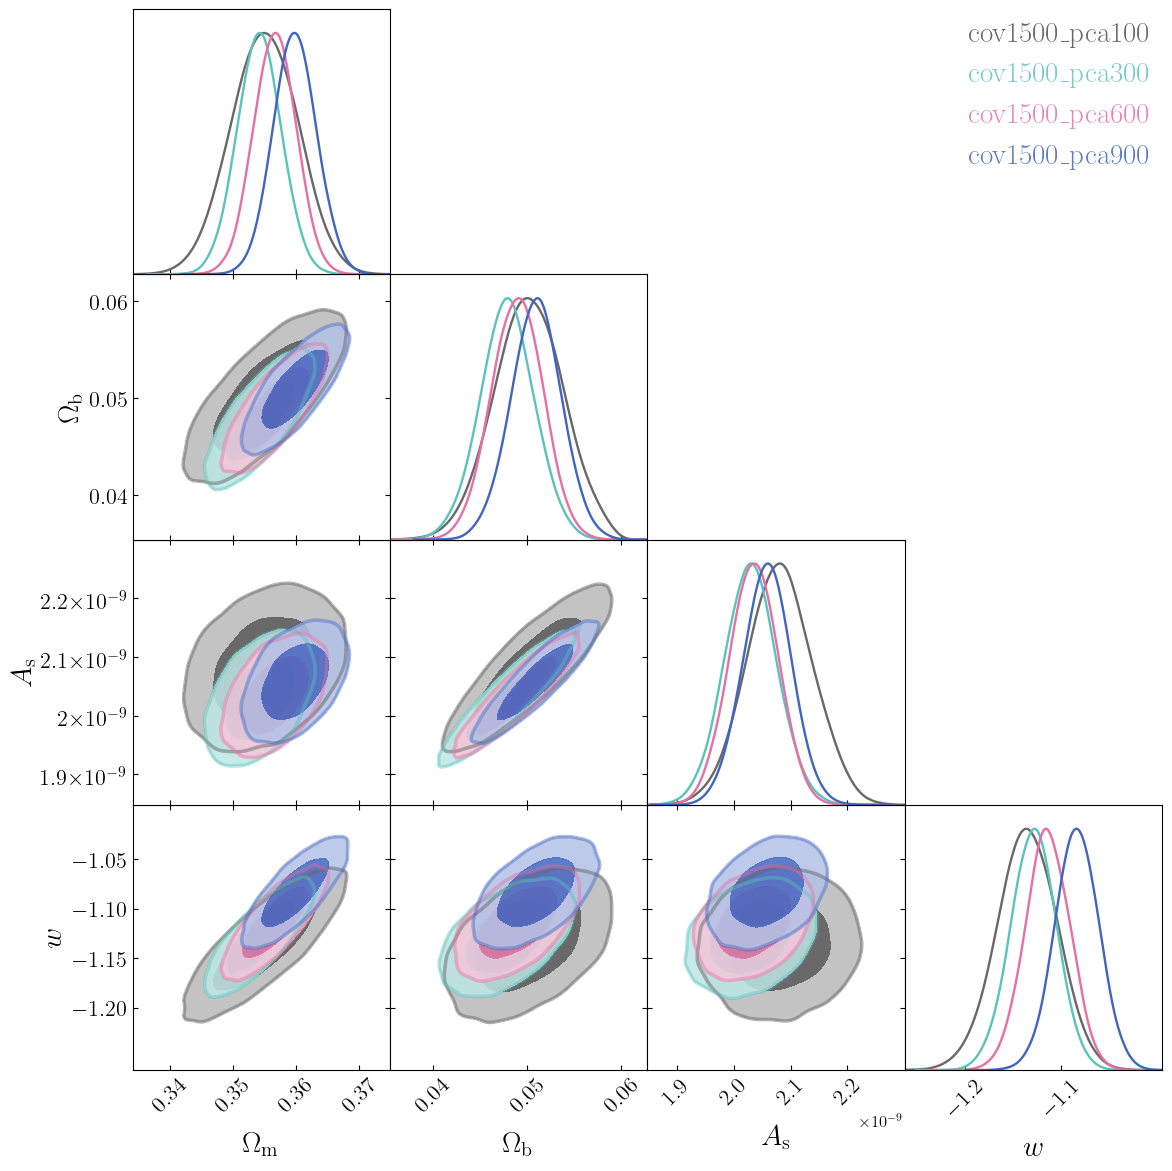

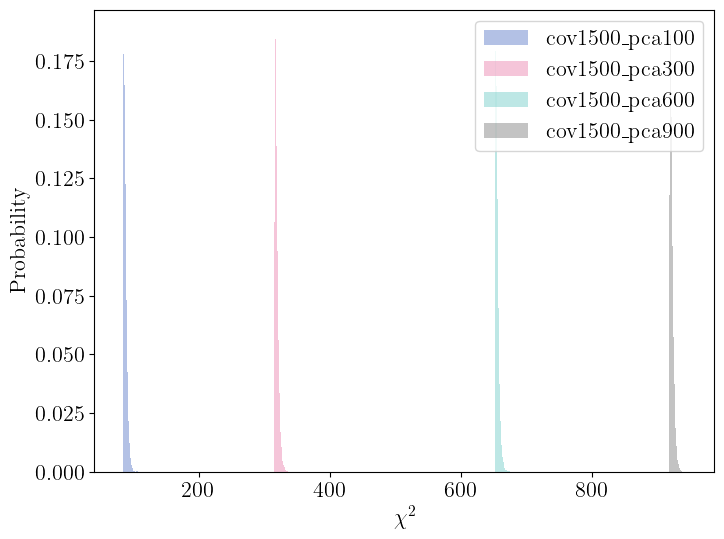

In [37]:
# plots for the numerical covariance matrix from 1500 vectors with 100, 300, 600 and 900 PCA elements

plot_posteriors([samples_cov1500_pca100,samples_cov1500_pca300,samples_cov1500_pca600,samples_cov1500_pca900],
                labels=['cov1500_pca100','cov1500_pca300','cov1500_pca600','cov1500_pca900'])
plt.savefig('data_4_assignment3/plots/cov1500_pca_posteriors.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plot_chi2([log_prob_samples_cov1500_pca100,log_prob_samples_cov1500_pca300,log_prob_samples_cov1500_pca600,log_prob_samples_cov1500_pca900],
           labels=['cov1500_pca100','cov1500_pca300','cov1500_pca600','cov1500_pca900'])
plt.savefig('data_4_assignment3/plots/cov1500_pca_chi2.jpg',dpi=600, bbox_inches='tight')
plt.show()

We see from the posteriors that, once again, including more PCA elements leads to tighter constraints and slightly shifts the mean value for each parameter. Once again, 600 PCA compression seems to yield approximately the same width of constraints as the 900 PCA run. However, when using the numerical covariance matrix as opposed to the analytic one in 3a, different numbers of PCA elements consistently shifts the mean value of the parameters quite noticeably. While the contours from 600 PCA elements overlapped very well with those from 900 elements when using the analytic matrix in 3a, they do not overlap with the numerical matrix here, despite the contours having roughly the same width. This suggests that when using a noisy covariance matrix, PCA compression is less effective at yielding accurate results.

We see that the $\chi^2$ distributions from the numerical matrix are very similar to those for the analytic matrix, peaking only slightly higher than in the analytic case for each level of PCA compression.

### 4. Run task 3 with the noise-free reference model. What difference do you observe in the MCMC chain and the corresponding $\chi^2$ distributions?

All of the following cells preceding Question 4a are identical to those from Question 3, only with the noiseless reference model used for each of the MCMC runs.

In [38]:
# MCMC with the analytic covariance matrix, noiseless reference model and 100 PCA elements

pca,model,cov_inv = make_pca_parts(100,cov,reference_model,False)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_covTrue_pca100_clean = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca100_clean',samples_covTrue_pca100_clean)
log_prob_samples_covTrue_pca100_clean = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_covTrue_pca100_clean',log_prob_samples_covTrue_pca100_clean)

100%|██████████| 3000/3000 [15:24<00:00,  3.25it/s]


In [39]:
# MCMC with the analytic covariance matrix, noiseless reference model and 300 PCA elements

pca,model,cov_inv = make_pca_parts(300,cov,reference_model,False)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_covTrue_pca300_clean = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca300_clean',samples_covTrue_pca300_clean)
log_prob_samples_covTrue_pca300_clean = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_covTrue_pca300_clean',log_prob_samples_covTrue_pca300_clean)

100%|██████████| 3000/3000 [14:29<00:00,  3.45it/s]


In [40]:
# MCMC with the analytic covariance matrix, noiseless reference model and 600 PCA elements

pca,model,cov_inv = make_pca_parts(600,cov,reference_model,False)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_covTrue_pca600_clean = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca600_clean',samples_covTrue_pca600_clean)
log_prob_samples_covTrue_pca600_clean = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_covTrue_pca600_clean',log_prob_samples_covTrue_pca600_clean)

100%|██████████| 3000/3000 [14:27<00:00,  3.46it/s]


In [41]:
# MCMC with the analytic covariance matrix, noiseless reference model and 900 PCA elements

pca,model,cov_inv = make_pca_parts(900,cov,reference_model,False)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_covTrue_pca900_clean = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca900_clean',samples_covTrue_pca900_clean)
log_prob_samples_covTrue_pca900_clean = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_covTrue_pca900_clean',log_prob_samples_covTrue_pca900_clean)

100%|██████████| 3000/3000 [15:55<00:00,  3.14it/s]


In [42]:
# load in the MCMC samples and log probabilities for the analytic covariance matrix
# and the noiseless reference model with various PCA elements numbers from saved files

#samples_covTrue_pca100_clean = np.load('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca100_clean.npy')
#samples_covTrue_pca300_clean = np.load('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca300_clean.npy')
#samples_covTrue_pca600_clean = np.load('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca600_clean.npy')
#samples_covTrue_pca900_clean = np.load('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca900_clean.npy')
#
#log_prob_samples_covTrue_pca100_clean = np.load('data_4_assignment3/outputs_MCMC/logp_covTrue_pca100_clean.npy')
#log_prob_samples_covTrue_pca300_clean = np.load('data_4_assignment3/outputs_MCMC/logp_covTrue_pca300_clean.npy')
#log_prob_samples_covTrue_pca600_clean = np.load('data_4_assignment3/outputs_MCMC/logp_covTrue_pca600_clean.npy')
#log_prob_samples_covTrue_pca900_clean = np.load('data_4_assignment3/outputs_MCMC/logp_covTrue_pca900_clean.npy')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


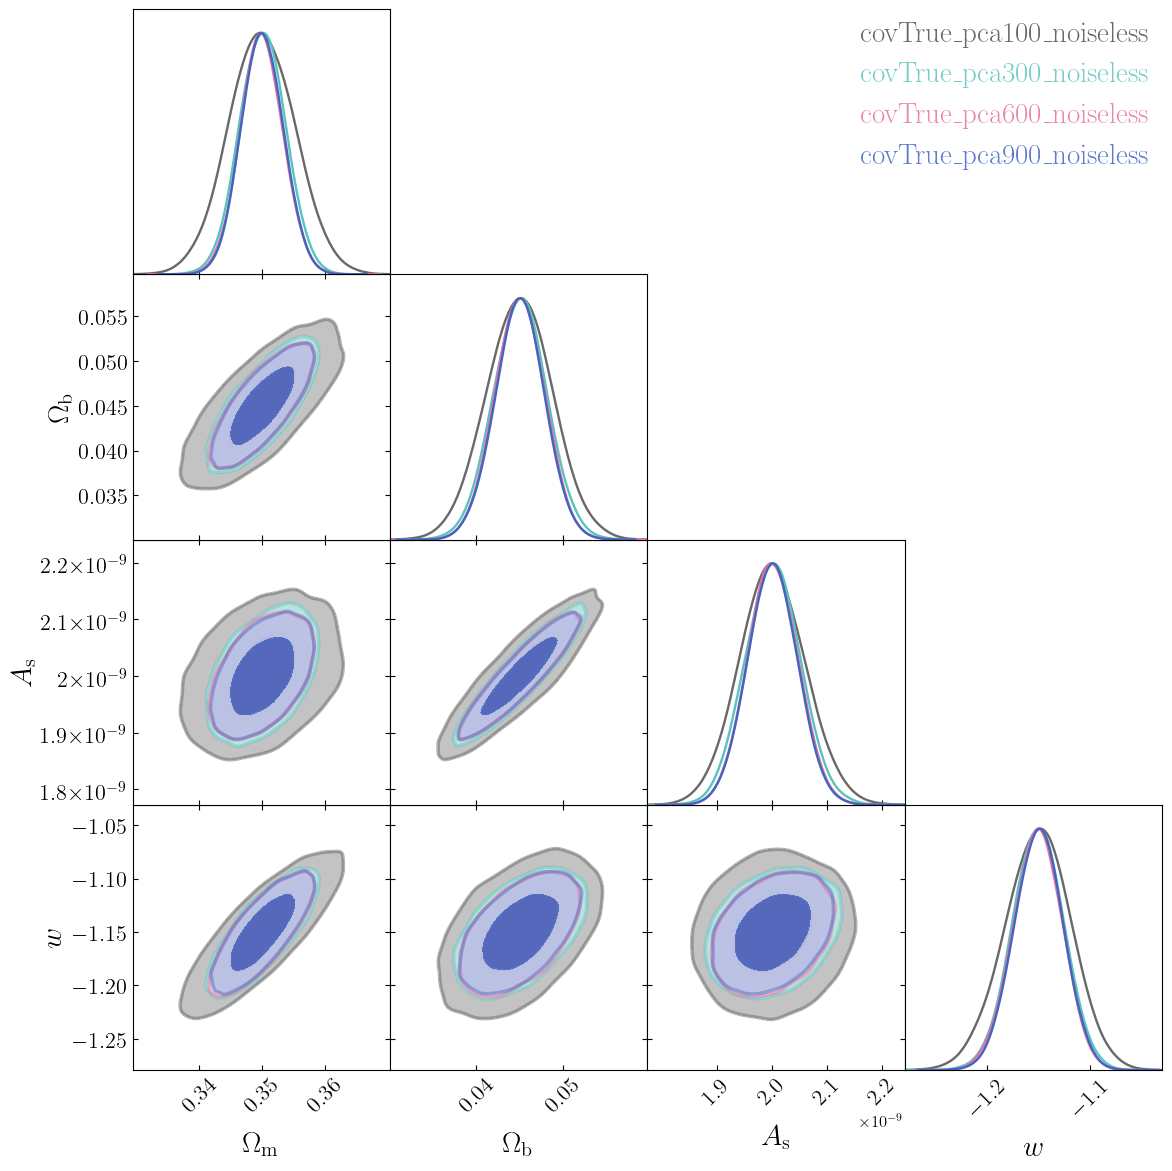

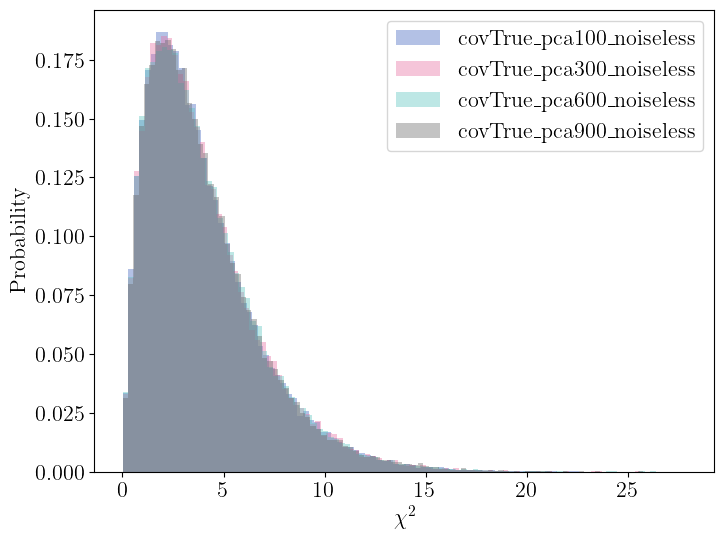

In [43]:
# plots for the analytic covariance matrix and noiseless reference model with 100, 300, 600 and 900 PCA elements

plot_posteriors([samples_covTrue_pca100_clean,samples_covTrue_pca300_clean,samples_covTrue_pca600_clean,samples_covTrue_pca900_clean],
                labels=['covTrue_pca100_noiseless','covTrue_pca300_noiseless','covTrue_pca600_noiseless','covTrue_pca900_noiseless'])
plt.savefig('data_4_assignment3/plots/covTrue_pca_noNoise_posteriors.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plot_chi2([log_prob_samples_covTrue_pca100_clean,log_prob_samples_covTrue_pca300_clean,log_prob_samples_covTrue_pca600_clean,log_prob_samples_covTrue_pca900_clean],
           labels=['covTrue_pca100_noiseless','covTrue_pca300_noiseless','covTrue_pca600_noiseless','covTrue_pca900_noiseless'])
plt.savefig('data_4_assignment3/plots/covTrue_pca_noNoise_chi2.jpg',dpi=600, bbox_inches='tight')
plt.show()

We see from the above plots that using the noiseless model and the analytic covariance matrix leads to PCA compression being much more effective. The countours in the posteriors plot are consistently centred around the same mean regardless of the number of PCA elements, which was not the case for the noisy model. Additionally, 300 PCA elements is nearly enough to achieve the same level of constraining power as 900 PCA elements, meaning that greater levels of compression are possible while still retaining sufficient information when using the noiseless model.

We also see that the $\chi^2$ distributions for each number of PCA elements with the noiseless model are effectively identical and peak around a value of 2. This is very different from the behaviour that we have seen from any of the previous MCMC runs with the noisy model. It seems that this difference is due to there being far fewer degrees of freedom in  the noiseless model. With the noisy model, each of the points along the vector can vary randomly, resulting in degrees of freedom equal to the number of points. This explains why the $\chi^2$ distributions peak near the number of PCA elements in Question 3, for example. However, the points in the noiseless model are determined entirely from the four specified model parameters, resulting in only those four degrees of freedom. This explains why the above $\chi^2$ distribution for the noiseless model resembles that which would be expected for a system with only 4 degrees of freedom. These degrees of freedom due to the model parameters also help to explain why previous $\chi^2$ distributions in Questions 1 and 3 peak at slightly above the dimension of the model vector.

Now, we run MCMCs for the noiseless reference model using the numerical covariance matrix generated from 1500 model vectors.

In [44]:
# MCMC with the numerical covariance matrix from 1500 vectors, noiseless reference model and 100 PCA elements

pca,model,cov_inv = make_pca_parts(100,cov_num_1500,reference_model,True)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov1500_pca100_clean = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca100_clean',samples_cov1500_pca100_clean)
log_prob_samples_cov1500_pca100_clean = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov1500_pca100_clean',log_prob_samples_cov1500_pca100_clean)

100%|██████████| 3000/3000 [21:46<00:00,  2.30it/s]


In [45]:
# MCMC with the numerical covariance matrix from 1500 vectors, noiseless reference model and 300 PCA elements

pca,model,cov_inv = make_pca_parts(300,cov_num_1500,reference_model,True)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov1500_pca300_clean = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca300_clean',samples_cov1500_pca300_clean)
log_prob_samples_cov1500_pca300_clean = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov1500_pca300_clean',log_prob_samples_cov1500_pca300_clean)

100%|██████████| 3000/3000 [13:36<00:00,  3.67it/s]


In [46]:
# MCMC with the numerical covariance matrix from 1500 vectors, noiseless reference model and 600 PCA elements

pca,model,cov_inv = make_pca_parts(600,cov_num_1500,reference_model,True)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov1500_pca600_clean = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca600_clean',samples_cov1500_pca600_clean)
log_prob_samples_cov1500_pca600_clean = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov1500_pca600_clean',log_prob_samples_cov1500_pca600_clean)

100%|██████████| 3000/3000 [13:23<00:00,  3.73it/s]


In [47]:
# MCMC with the numerical covariance matrix from 1500 vectors, noiseless reference model and 900 PCA elements

pca,model,cov_inv = make_pca_parts(900,cov_num_1500,reference_model,True)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov1500_pca900_clean = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca900_clean',samples_cov1500_pca900_clean)
log_prob_samples_cov1500_pca900_clean = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov1500_pca900_clean',log_prob_samples_cov1500_pca900_clean)

100%|██████████| 3000/3000 [13:48<00:00,  3.62it/s]


In [48]:
# load in the MCMC samples and log probabilities for the numerical covariance matrix from 1500 vectors
# and the noiseless reference model with various PCA elements numbers from saved files

#samples_cov1500_pca100_clean = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca100_clean.npy')
#samples_cov1500_pca300_clean = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca300_clean.npy')
#samples_cov1500_pca600_clean = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca600_clean.npy')
#samples_cov1500_pca900_clean = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca900_clean.npy')
#
#log_prob_samples_cov1500_pca100_clean = np.load('data_4_assignment3/outputs_MCMC/logp_cov1500_pca100_clean.npy')
#log_prob_samples_cov1500_pca300_clean = np.load('data_4_assignment3/outputs_MCMC/logp_cov1500_pca300_clean.npy')
#log_prob_samples_cov1500_pca600_clean = np.load('data_4_assignment3/outputs_MCMC/logp_cov1500_pca600_clean.npy')
#log_prob_samples_cov1500_pca900_clean = np.load('data_4_assignment3/outputs_MCMC/logp_cov1500_pca900_clean.npy')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


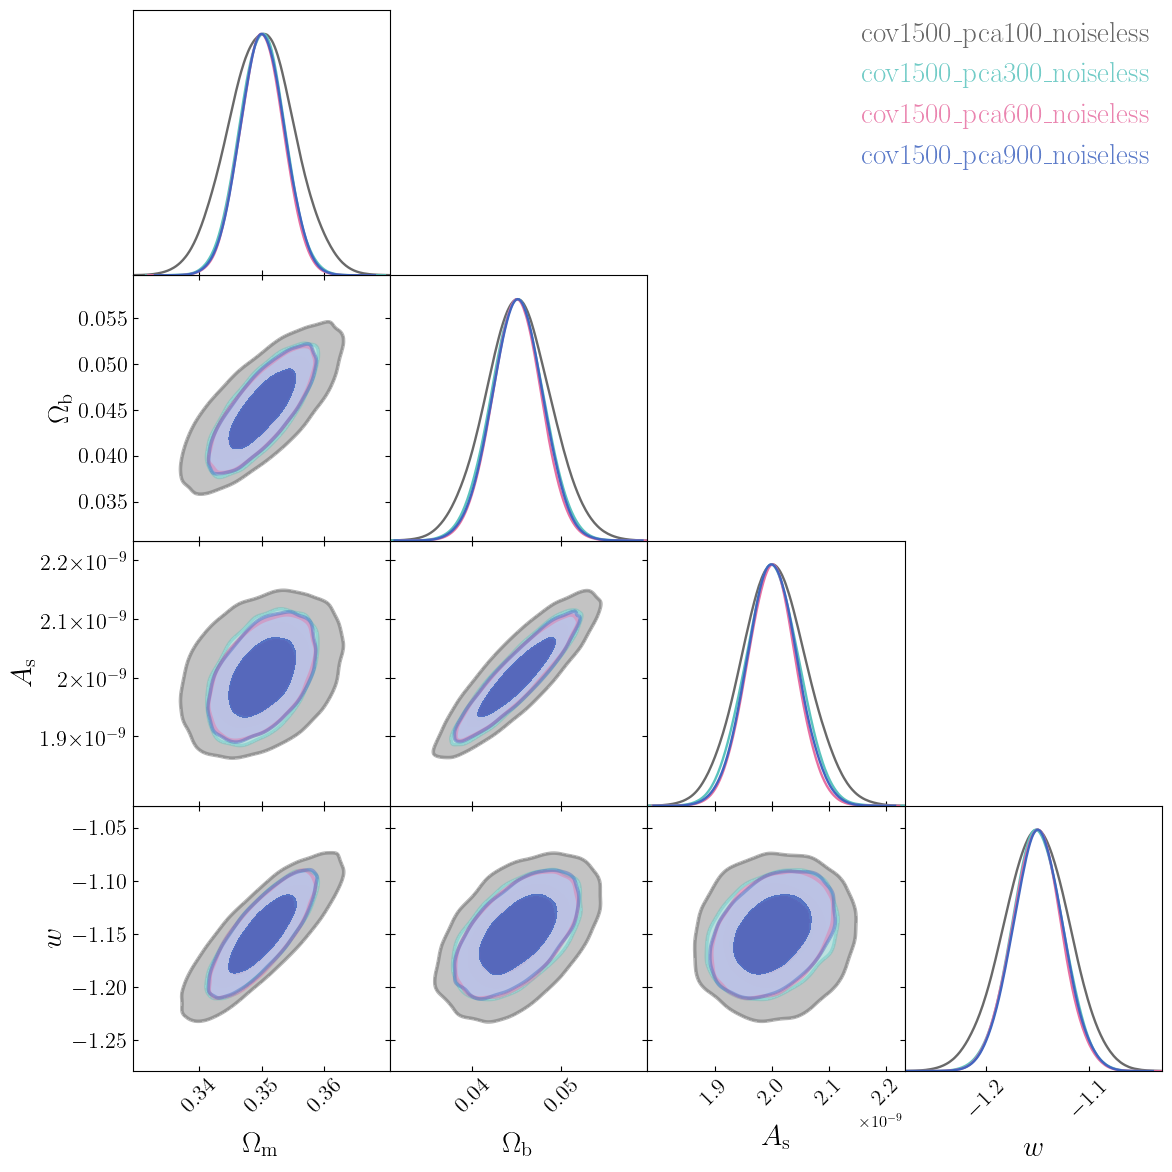

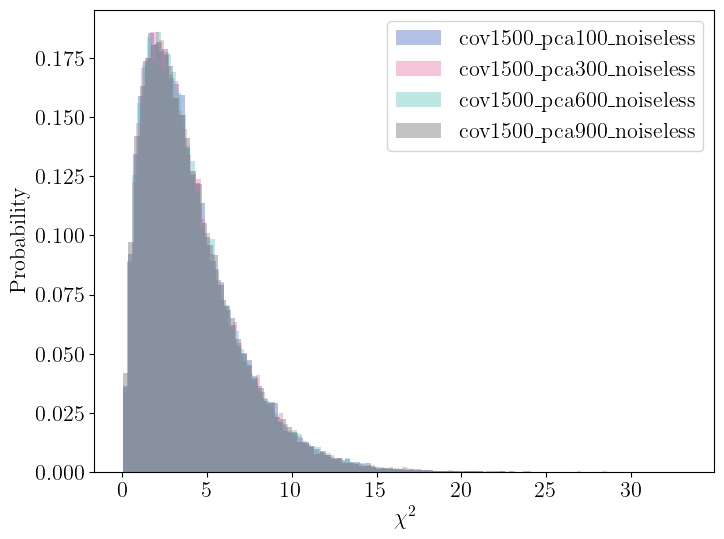

In [49]:
# plots for the numerical covariance matrix from 1500 vectors and noiseless reference model with 100, 300, 600 and 900 PCA elements

plot_posteriors([samples_cov1500_pca100_clean,samples_cov1500_pca300_clean,samples_cov1500_pca600_clean,samples_cov1500_pca900_clean],
                labels=['cov1500_pca100_noiseless','cov1500_pca300_noiseless','cov1500_pca600_noiseless','cov1500_pca900_noiseless'])
plt.savefig('data_4_assignment3/plots/cov1500_pca_noNoise_posteriors.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plot_chi2([log_prob_samples_cov1500_pca100_clean,log_prob_samples_cov1500_pca300_clean,log_prob_samples_cov1500_pca600_clean,log_prob_samples_cov1500_pca900_clean],
           labels=['cov1500_pca100_noiseless','cov1500_pca300_noiseless','cov1500_pca600_noiseless','cov1500_pca900_noiseless'])
plt.savefig('data_4_assignment3/plots/cov1500_pca_noNoise_chi2.jpg',dpi=600, bbox_inches='tight')
plt.show()

We see from the above plots that using the noiseless model and the numerical covariance matrix computed from 1500 vectors leads to nearly the exact same results as when we used the analytic covariance matrix. Both the posteriors triangle plot and the $\chi^2$ distributions are effectively the same as those generated using the analytic matrix. This behaviour is quite different from what we saw in the previous questions, where the numerical covariance matrices generally perform more poorly, as we would expect since they are more noisy. We thus conclude that using a noisy or noiseless reference model has a much greater impact on the precision and accuracy of PCA compression than using a numerical or analytic covariance matrix. Most notably, the PCA fitting remains effective for lower numbers of PCA elements with the noiseless model, and the number of PCA elements does not affect the mean parameters when using a noiseless model.

This presents a significant improvement over what we saw in Assignment 2, where we used noisy models, as far fewer than 600 PCA elements are apparently required to match the constraining power of uncompressed data when using an MCMC and a noiseless model.

#### 4.a Plot and compare the marginalised constraints on $\Omega_\mathrm{m}$ and $A_s$, as a function of the number of PCA elements. What do you observe?

Here, we run MCMCs using the numerical covariance matrix generated from 1500 vectors for a variety of PCA elements. From preliminary runs, we noticed that the differences in results are more pronounced when using fewer PCA elements. So, we run the MCMC for more small numbers of PCA elements than large numbers of elements. We then save the mean values of $\Omega_m$ and $A_s$ for each run, as well as the constraints (square roots of the variances).

In [50]:
parameter_constraints = [] # initialize an array for parameter constraints

N_pcas = [2,3,4,5,7,10,15,25,40,70,100,200,300,500,700,900] # numbers of PCA elements for which to compute the contraints

# run an MCMC with the numerical covariance matrix from 1500 vectors and the noiseless reference model
# for each number of PCA elements and save the resulting parameter constraints
for N_pca in N_pcas:
    # get the fitted PCA, transformed model and rotated covariance matrix
    pca,model,cov_inv = make_pca_parts(N_pca,cov_num_1500,reference_model,True)
    
    p0 = start_position_lh_and_step_size() # get the initial positions of the walkers

    # run the MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
    sampler.run_mcmc(p0, total_steps, progress=True)

    # get the samples
    samples_getdist = MCSamples(samples=sampler.get_chain(discard=burning_steps,flat=True), settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})
    means = samples_getdist.getMeans()[[0,2]] # save the mean values for each parameter
    sigmas = np.sqrt(samples_getdist.getVars()[[0,2]]) # save the constraints of the distribution for each parameter

    parameter_constraints.append([means,sigmas]) # append the means and constraints to the parameter constraints list

parameter_constraints = np.array(parameter_constraints) # convert the constraints list to an array

np.save('data_4_assignment3/outputs_MCMC/parameter_constraints',parameter_constraints) # save the constraints to a file

100%|██████████| 3000/3000 [11:46<00:00,  4.24it/s]


Removed no burn in


100%|██████████| 3000/3000 [11:44<00:00,  4.26it/s]


Removed no burn in


100%|██████████| 3000/3000 [11:38<00:00,  4.29it/s]


Removed no burn in


100%|██████████| 3000/3000 [11:39<00:00,  4.29it/s]


Removed no burn in


100%|██████████| 3000/3000 [11:41<00:00,  4.28it/s]


Removed no burn in


100%|██████████| 3000/3000 [11:47<00:00,  4.24it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:41<00:00,  3.94it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:43<00:00,  3.93it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:44<00:00,  3.92it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:47<00:00,  3.91it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:58<00:00,  3.85it/s]


Removed no burn in


100%|██████████| 3000/3000 [13:16<00:00,  3.77it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:49<00:00,  3.90it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:44<00:00,  3.92it/s]


Removed no burn in


100%|██████████| 3000/3000 [13:13<00:00,  3.78it/s]


Removed no burn in


100%|██████████| 3000/3000 [13:42<00:00,  3.65it/s]

Removed no burn in


In [51]:
# load the parameter constraints from a file
#parameter_constraints = np.load('data_4_assignment3/outputs_MCMC/parameter_constraints.npy')

omega_m_means = parameter_constraints[:,0,0] # the mean values for Omega_m
As_means = parameter_constraints[:,0,1] # the mean values for A_s
omega_m_sigmas = parameter_constraints[:,1,0] # the constraints for Omega_m
As_sigmas = parameter_constraints[:,1,1] # the constraints for A_s

Below, we plot the values of $\Omega_m$ and $A_s$, respectively, as functions of the number of PCA elements. The solid lines are the mean values of each parameter, and their constraints are shaded regions around the means.

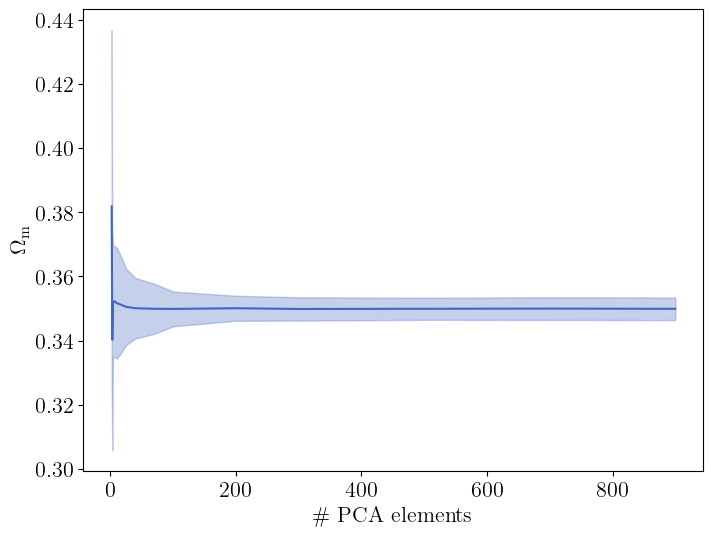

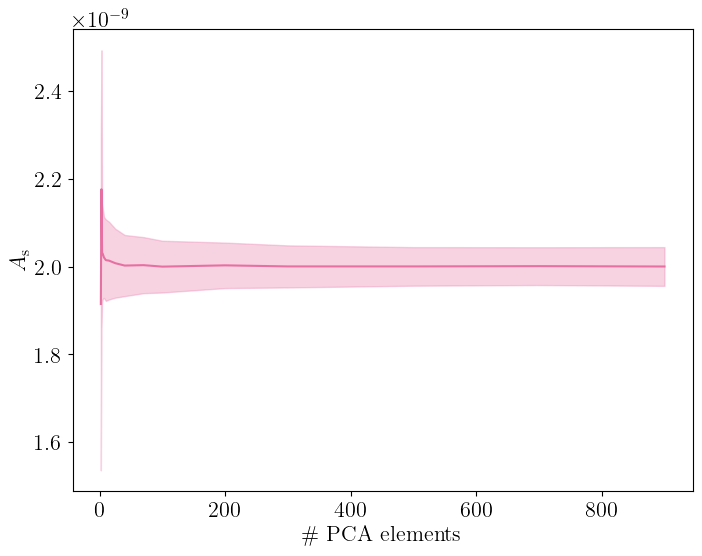

In [52]:
# plot the means and constraints for Omega_m
plt.figure(figsize=(8,6),dpi=100)
plt.plot(N_pcas,omega_m_means,color='#4165c0')
plt.fill_between(N_pcas, omega_m_means-omega_m_sigmas, omega_m_means+omega_m_sigmas, color='#4165c0',alpha=0.3)
plt.xlabel('\# PCA elements')
plt.ylabel('$\Omega_\mathrm{m}$')
plt.savefig('data_4_assignment3/plots/pca_Omegam_all.jpg',dpi=600, bbox_inches='tight')
plt.show()

# plot the means and constraints for A_s
plt.figure(figsize=(8,6),dpi=100)
plt.plot(N_pcas,As_means,color='#e770a2')
plt.fill_between(N_pcas, As_means-As_sigmas, As_means+As_sigmas, color='#e770a2',alpha=0.3)
plt.xlabel('\# PCA elements')
plt.ylabel('$A_\mathrm{s}$')
plt.savefig('data_4_assignment3/plots/pca_As_all.jpg',dpi=600, bbox_inches='tight')
plt.show()

We see that for very low numbers of PCA elements, there is some scatter in the mean values of the parameters, especially for the $A_s$ parameter. This scatter is very exagerated for 2 or 3 PCA elements. However, above these low levels of PCA compression, the mean value remains fairly stable. We also see that the constraints decrease as a function of the number of PCA elements significantly at the beginning, but they quickly level out. This suggests that as we increase the number of PCA elements, the accuracy and precision of our parameter estimates improve less and less significantly. To get a better look at this trend in detail, we'll make the same plots below, cutting out the first couple of points with large scatter.

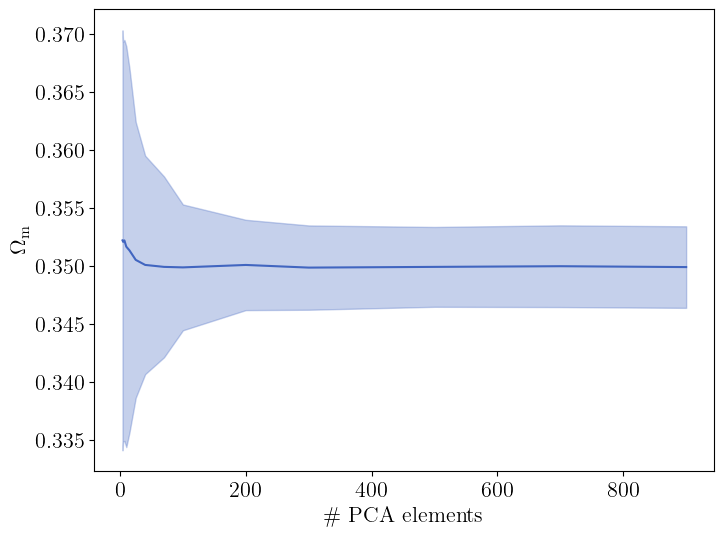

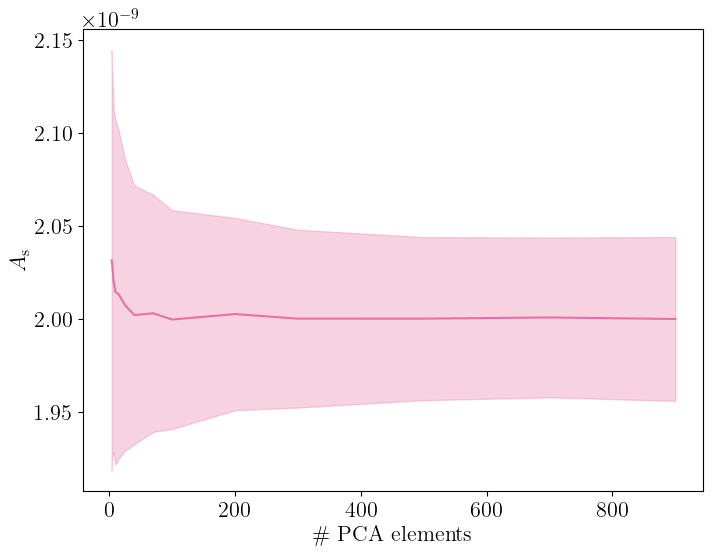

In [53]:
# plot the means and constraints for Omega_m
plt.figure(figsize=(8,6),dpi=100)
plt.plot(N_pcas[2:],omega_m_means[2:],color='#4165c0')
plt.fill_between(N_pcas[2:], omega_m_means[2:]-omega_m_sigmas[2:], omega_m_means[2:]+omega_m_sigmas[2:], color='#4165c0',alpha=0.3)
plt.xlabel('\# PCA elements')
plt.ylabel('$\Omega_\mathrm{m}$')
plt.savefig('data_4_assignment3/plots/pca_Omegam_cut.jpg',dpi=600, bbox_inches='tight')
plt.show()

# plot the means and constraints for A_s
plt.figure(figsize=(8,6),dpi=100)
plt.plot(N_pcas[2:],As_means[2:],color='#e770a2')
plt.fill_between(N_pcas[2:], As_means[2:]-As_sigmas[2:], As_means[2:]+As_sigmas[2:], color='#e770a2',alpha=0.3)
plt.xlabel('\# PCA elements')
plt.ylabel('$A_\mathrm{s}$')
plt.savefig('data_4_assignment3/plots/pca_As_cut.jpg',dpi=600, bbox_inches='tight')
plt.show()

We see the same trend in the above plots as we did in the previous pair. In these plots, we can tell that the constraints on $\Omega_m$ don't improve significantly beyond approximately 300 PCA elements, and those for $A_s$ don't improve much beyond 500 PCA elements. This is consistent with our finding in Question 3 that the constraints don't significantly improve beyong 500-600 PCA elements. It is similarly consistent with our results in Assignment 2 that approximately 500 PCA elements are required to get within 1% the constraining power of an uncompressed analysis.

#### 4.b To check if your answer in 4.a is robust, run multiple MCMC chains with the 1.5 covariance matrix and a fixed number of PCA elements. How big are the variations on the marginalised errors on $\Omega_\mathrm{m}$ and $A_s$? Is your answer in 4.a reliable? What can you improve to make 4.a reliable?

Here, we run 16 MCMC chains using the numerical covariance matrix from 1500 vectors with 100 PCA elements. We record the same information as in Question 4a.

In [54]:
parameter_constraints_100 = [] # initialize an array for parameter constraints

# run an MCMC with the numerical covariance matrix from 1500 vectors and the noiseless reference model
# for 100 PCA elements 16 times and save the resulting parameter constraints
for i in range(16):
    # get the fitted PCA, transformed model and rotated covariance matrix
    pca,model,cov_inv = make_pca_parts(100,cov_num_1500,reference_model,True)
    
    p0 = start_position_lh_and_step_size() # get the initial positions of the walkers

    # run the MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
    sampler.run_mcmc(p0, total_steps, progress=True)

    # get the samples
    samples_getdist = MCSamples(samples=sampler.get_chain(discard=burning_steps,flat=True), settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})
    means = samples_getdist.getMeans()[[0,2]] # save the mean values for each parameter
    sigmas = np.sqrt(samples_getdist.getVars()[[0,2]]) # save the constraints of the distribution for each parameter

    parameter_constraints_100.append([means,sigmas]) # append the means and constraints to the parameter constraints list

parameter_constraints_100 = np.array(parameter_constraints_100) # convert the constraints list to an array

np.save('data_4_assignment3/outputs_MCMC/parameter_constraints_100',parameter_constraints_100) # save the constraints to a file

100%|██████████| 3000/3000 [13:01<00:00,  3.84it/s]


Removed no burn in


100%|██████████| 3000/3000 [13:01<00:00,  3.84it/s]


Removed no burn in


100%|██████████| 3000/3000 [13:02<00:00,  3.83it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:55<00:00,  3.87it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:59<00:00,  3.85it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:55<00:00,  3.87it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:57<00:00,  3.86it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:57<00:00,  3.86it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:57<00:00,  3.86it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:55<00:00,  3.87it/s]


Removed no burn in


100%|██████████| 3000/3000 [13:00<00:00,  3.84it/s]


Removed no burn in


100%|██████████| 3000/3000 [13:00<00:00,  3.84it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:57<00:00,  3.86it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:57<00:00,  3.86it/s]


Removed no burn in


100%|██████████| 3000/3000 [13:15<00:00,  3.77it/s]


Removed no burn in


100%|██████████| 3000/3000 [14:09<00:00,  3.53it/s]

Removed no burn in


In [55]:
# load the parameter constraints from a file
#parameter_constraints_100 = np.load('data_4_assignment3/outputs_MCMC/parameter_constraints_100.npy')

omega_m_means = parameter_constraints_100[:,0,0] # the mean values for Omega_m
As_means = parameter_constraints_100[:,0,1] # the mean values for A_s
omega_m_sigmas = parameter_constraints_100[:,1,0] # the constraints for Omega_m
As_sigmas = parameter_constraints_100[:,1,1] # the constraints for A_s

In the following cell, we print out the means and standard deviations of the means and constraints for both $\Omega_m$ and $A_s$ across the 16 MCMC runs.

In [56]:
# print the means of the mean values and constraints for Omega_m and A_s,
# as well as the standard deviations on each
print('omega_m mean:\t {:.5f} ± {:.5f}'.format(np.mean(omega_m_means),np.std(omega_m_means)))
print('omega_m sigma:\t {:.5f} ± {:.5f}'.format(np.mean(omega_m_sigmas),np.std(omega_m_sigmas)))
print('As mean:\t {:.4e} ± {:.2e}'.format(np.mean(As_means),np.std(As_means)))
print('As sigma:\t {:.4e} ± {:.2e}'.format(np.mean(As_sigmas),np.std(As_sigmas)))

omega_m mean:	 0.35000 ± 0.00010
omega_m sigma:	 0.00535 ± 0.00003
As mean:	 2.0014e-09 ± 1.03e-12
As sigma:	 5.8813e-11 ± 3.63e-13


We see above that the means for both parameters are quite stable, with standard deviations of less than 0.1% of their values. The constraints are also rather stable, with standard deviations of less than 1%. This suggests that the results for Question 4a are very reliable. Interestingly, though 100 PCA elements did not tend to produce very strong constraints in comparison to greater numbers of PCA elements, the results from this level of PCA compression are still clearly very consistent across different runs.

Below, we plot the means and constraints for each run as points, and we plot the means of each data set as a line. The following cell does so for $\Omega_m$, and the next does so for $A_s$.

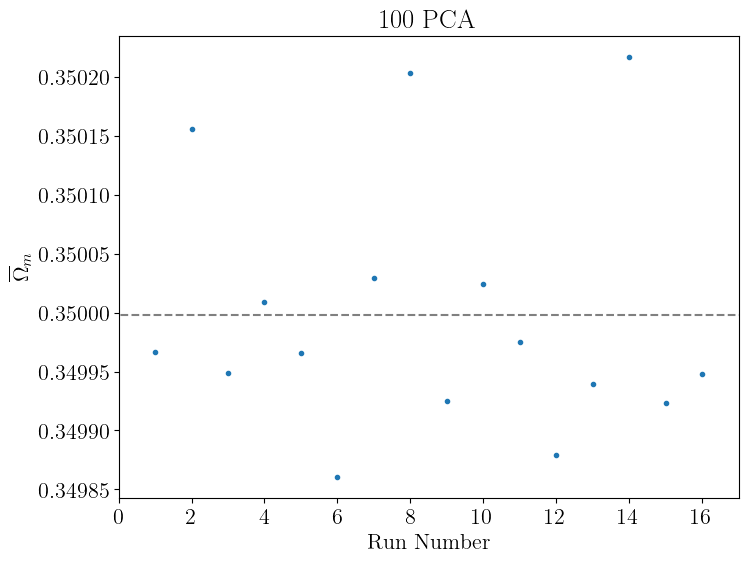

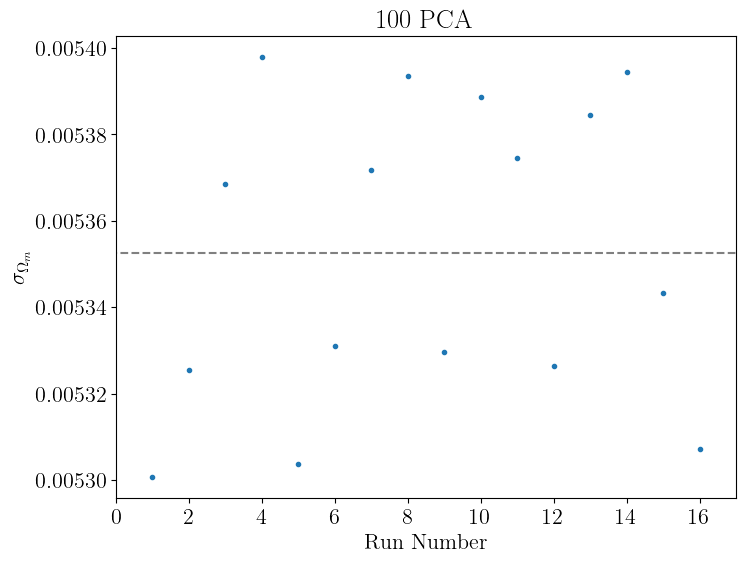

In [57]:
# plot the mean Omega_m values and the mean of the means
plt.figure(figsize=(8,6),dpi=100)
plt.hlines(np.mean(omega_m_means),-5,20,'grey','--')
plt.plot(np.arange(1,len(omega_m_means)+1),omega_m_means,'.')
plt.xlim(0,17)
plt.title('100 PCA')
plt.xlabel('Run Number')
plt.ylabel('$\overline\Omega_m$')
plt.savefig('data_4_assignment3/plots/pca100_Omegam_mean.jpg',dpi=600, bbox_inches='tight')
plt.show()

# plot the constraints for the Omega_m values and the mean of these values
plt.figure(figsize=(8,6),dpi=100)
plt.hlines(np.mean(omega_m_sigmas),-5,20,'grey','--')
plt.plot(np.arange(1,len(omega_m_sigmas)+1),omega_m_sigmas,'.')
plt.xlim(0,17)
plt.title('100 PCA')
plt.xlabel('Run Number')
plt.ylabel('$\sigma_{\Omega_m}$')
plt.savefig('data_4_assignment3/plots/pca100_Omegam_std.jpg',dpi=600, bbox_inches='tight')
plt.show()

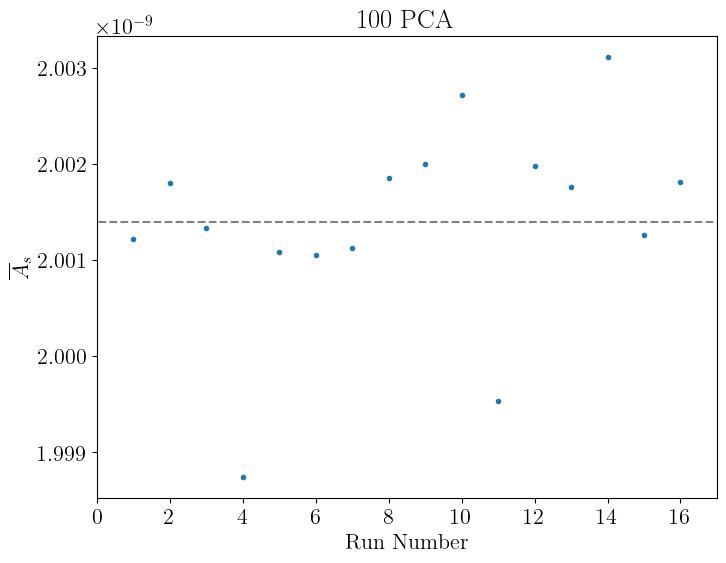

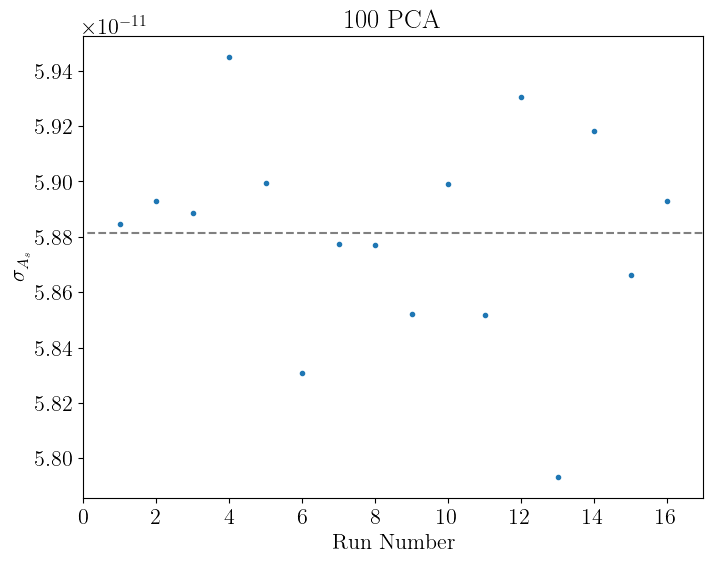

In [58]:
# plot the mean A_s values and the mean of the means
plt.figure(figsize=(8,6),dpi=100)
plt.hlines(np.mean(As_means),-5,20,'grey','--')
plt.plot(np.arange(1,len(As_means)+1),As_means,'.')
plt.xlim(0,17)
plt.title('100 PCA')
plt.xlabel('Run Number')
plt.ylabel('$\overline A_s$')
plt.savefig('data_4_assignment3/plots/pca100_As_mean.jpg',dpi=600, bbox_inches='tight')
plt.show()

# plot the constraints for the A_s values and the mean of these values
plt.figure(figsize=(8,6),dpi=100)
plt.hlines(np.mean(As_sigmas),-5,20,'grey','--')
plt.plot(np.arange(1,len(As_sigmas)+1),As_sigmas,'.')
plt.xlim(0,17)
plt.title('100 PCA')
plt.xlabel('Run Number')
plt.ylabel('$\sigma_{A_s}$')
plt.savefig('data_4_assignment3/plots/pca100_As_std.jpg',dpi=600, bbox_inches='tight')
plt.show()

We see that the scatter about the mean in each of the above plots is reflective of the values printed out previously. There seems to be no trend in the data, which is reassuring since we would expect the scatter between runs to be random.

Below, we repeat what we just completed for Question 4b, except we use 600 PCA elements rather than 100 to see if there is any significant change in the results for a lower level of compression.

In [59]:
parameter_constraints_600 = [] # initialize an array for parameter constraints

# run an MCMC with the numerical covariance matrix from 1500 vectors and the noiseless reference model
# for 600 PCA elements 16 times and save the resulting parameter constraints
for i in range(16):
    # get the fitted PCA, transformed model and rotated covariance matrix
    pca,model,cov_inv = make_pca_parts(600,cov_num_1500,reference_model,True)
    
    p0 = start_position_lh_and_step_size() # get the initial positions of the walkers

    # run the MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
    sampler.run_mcmc(p0, total_steps, progress=True)

    # get the samples
    samples_getdist = MCSamples(samples=sampler.get_chain(discard=burning_steps,flat=True), settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})
    means = samples_getdist.getMeans()[[0,2]] # save the mean values for each parameter
    sigmas = np.sqrt(samples_getdist.getVars()[[0,2]]) # save the constraints of the distribution for each parameter

    parameter_constraints_600.append([means,sigmas]) # append the means and constraints to the parameter constraints list

parameter_constraints_600 = np.array(parameter_constraints_600) # convert the constraints list to an array

np.save('data_4_assignment3/outputs_MCMC/parameter_constraints_600',parameter_constraints_600) # save the constraints to a file

100%|██████████| 3000/3000 [12:51<00:00,  3.89it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:53<00:00,  3.88it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:52<00:00,  3.88it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:53<00:00,  3.88it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:54<00:00,  3.87it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:51<00:00,  3.89it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:50<00:00,  3.89it/s]


Removed no burn in


100%|██████████| 3000/3000 [13:29<00:00,  3.70it/s]


Removed no burn in


100%|██████████| 3000/3000 [13:09<00:00,  3.80it/s]


Removed no burn in


100%|██████████| 3000/3000 [14:08<00:00,  3.54it/s]


Removed no burn in


100%|██████████| 3000/3000 [15:02<00:00,  3.32it/s]


Removed no burn in


100%|██████████| 3000/3000 [15:36<00:00,  3.20it/s]


Removed no burn in


100%|██████████| 3000/3000 [16:04<00:00,  3.11it/s]


Removed no burn in


100%|██████████| 3000/3000 [14:51<00:00,  3.37it/s]


Removed no burn in


100%|██████████| 3000/3000 [17:42<00:00,  2.82it/s]


Removed no burn in


100%|██████████| 3000/3000 [19:08<00:00,  2.61it/s]

Removed no burn in


In [60]:
# load the parameter constraints from a file
#parameter_constraints_600 = np.load('data_4_assignment3/outputs_MCMC/parameter_constraints_600.npy')

omega_m_means = parameter_constraints_600[:,0,0] # the mean values for Omega_m
As_means = parameter_constraints_600[:,0,1] # the mean values for A_s
omega_m_sigmas = parameter_constraints_600[:,1,0] # the constraints for Omega_m
As_sigmas = parameter_constraints_600[:,1,1] # the constraints for A_s

In [61]:
# print the means of the mean values and constraints for Omega_m and A_s,
# as well as the standard deviations on each
print('omega_m mean:\t {:.5f} ± {:.5f}'.format(np.mean(omega_m_means),np.std(omega_m_means)))
print('omega_m sigma:\t {:.5f} ± {:.5f}'.format(np.mean(omega_m_sigmas),np.std(omega_m_sigmas)))
print('As mean:\t {:.4e} ± {:.2e}'.format(np.mean(As_means),np.std(As_means)))
print('As sigma:\t {:.4e} ± {:.2e}'.format(np.mean(As_sigmas),np.std(As_sigmas)))

omega_m mean:	 0.34999 ± 0.00006
omega_m sigma:	 0.00346 ± 0.00002
As mean:	 2.0007e-09 ± 8.59e-13
As sigma:	 4.3784e-11 ± 2.73e-13


We see above that the above standard deviations in the means and constraints are slightly smaller than those for the 100 PCA elements used previously, but not dramatically so. This suggests again that the answer to 4a was reliable. It also suggests that using greater PCA compression does not greatly reduce the consistency of the results, even if it does affect the accuracy and precision.

Once again, we plot the means and constraints for each MCMC run below.

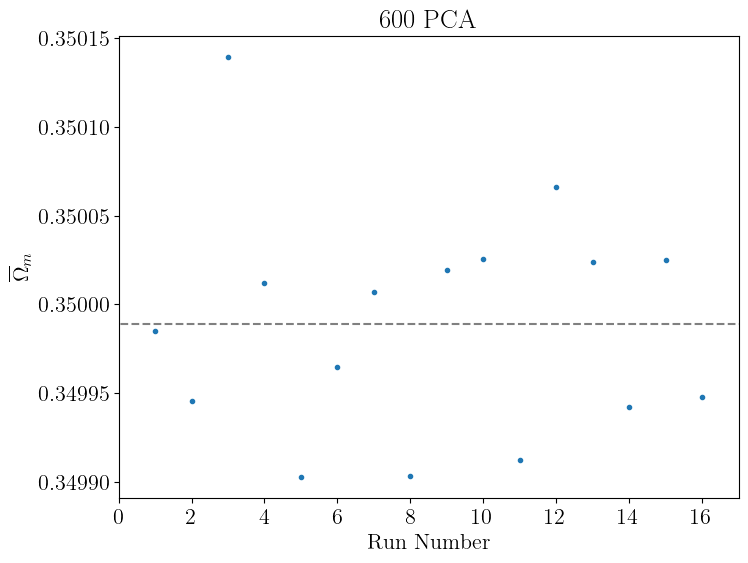

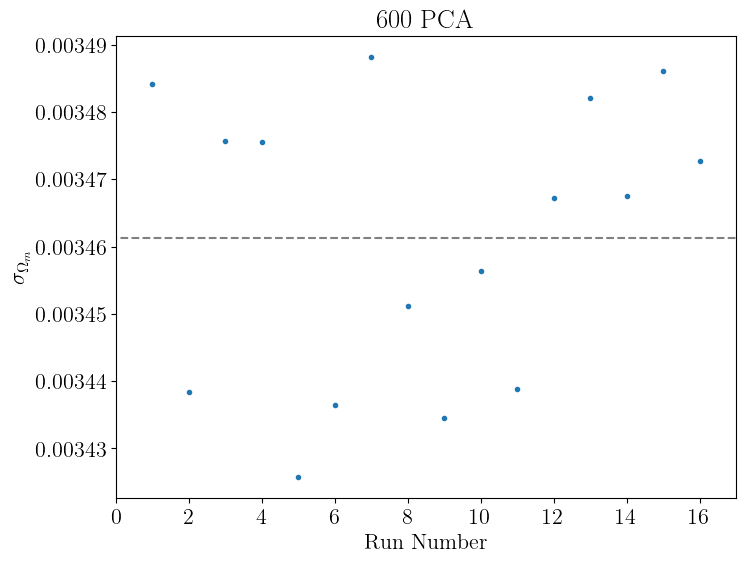

In [62]:
# plot the mean Omega_m values and the mean of the means
plt.figure(figsize=(8,6),dpi=100)
plt.hlines(np.mean(omega_m_means),-5,20,'grey','--')
plt.plot(np.arange(1,len(omega_m_means)+1),omega_m_means,'.')
plt.xlim(0,17)
plt.title('600 PCA')
plt.xlabel('Run Number')
plt.ylabel('$\overline\Omega_m$')
plt.savefig('data_4_assignment3/plots/pca600_Omegam_mean.jpg',dpi=600, bbox_inches='tight')
plt.show()

# plot the constraints for the Omega_m values and the mean of these values
plt.figure(figsize=(8,6),dpi=100)
plt.hlines(np.mean(omega_m_sigmas),-5,20,'grey','--')
plt.plot(np.arange(1,len(omega_m_sigmas)+1),omega_m_sigmas,'.')
plt.xlim(0,17)
plt.title('600 PCA')
plt.xlabel('Run Number')
plt.ylabel('$\sigma_{\Omega_m}$')
plt.savefig('data_4_assignment3/plots/pca600_Omegam_std.jpg',dpi=600, bbox_inches='tight')
plt.show()

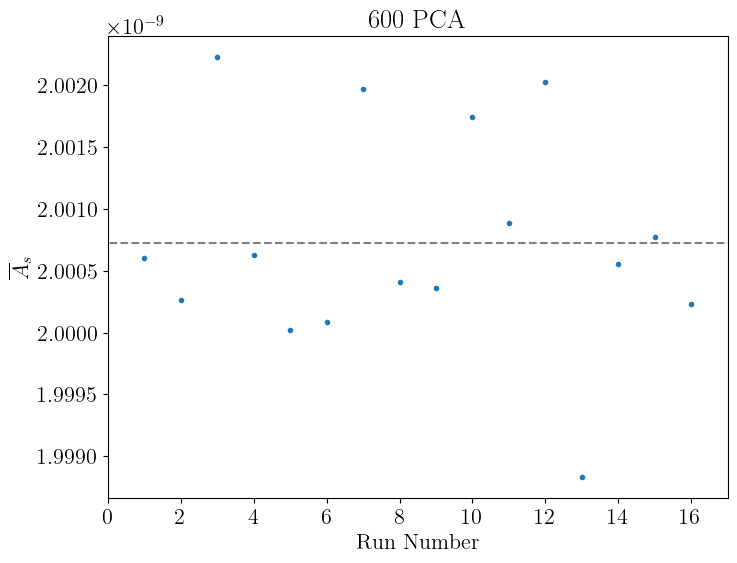

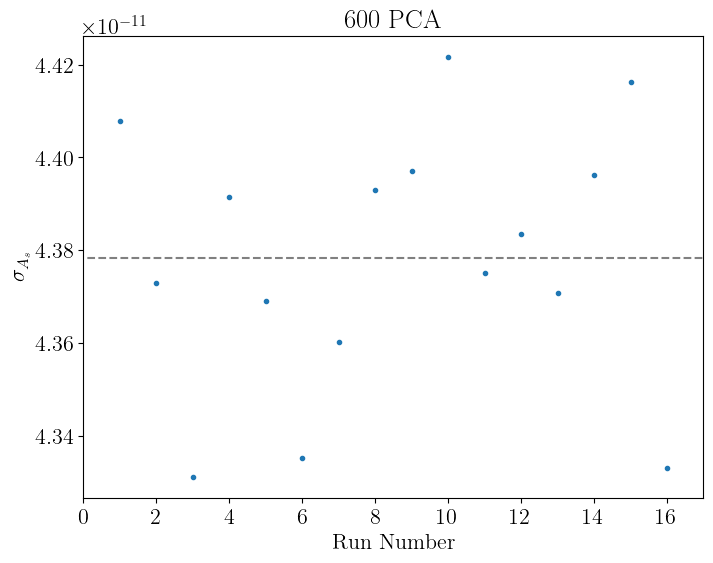

In [63]:
# plot the mean A_s values and the mean of the means
plt.figure(figsize=(8,6),dpi=100)
plt.hlines(np.mean(As_means),-5,20,'grey','--')
plt.plot(np.arange(1,len(As_means)+1),As_means,'.')
plt.xlim(0,17)
plt.title('600 PCA')
plt.xlabel('Run Number')
plt.ylabel('$\overline A_s$')
plt.savefig('data_4_assignment3/plots/pca600_As_mean.jpg',dpi=600, bbox_inches='tight')
plt.show()

# plot the constraints for the A_s values and the mean of these values
plt.figure(figsize=(8,6),dpi=100)
plt.hlines(np.mean(As_sigmas),-5,20,'grey','--')
plt.plot(np.arange(1,len(As_sigmas)+1),As_sigmas,'.')
plt.xlim(0,17)
plt.title('600 PCA')
plt.xlabel('Run Number')
plt.ylabel('$\sigma_{A_s}$')
plt.savefig('data_4_assignment3/plots/pca600_As_std.jpg',dpi=600, bbox_inches='tight')
plt.show()

Once again, we see no trend in the scatter about the means in the above plots. This confirms that the successive MCMC runs are inducing some small random scatter, but that our results are generally reliable.

To make the results for 4a more reliable, we could use more walkers or a greater number of steps in the MCMC chain. Either of these options would allows the walkers to more fully explore the parameter space, allowing for more consistent values of the means and constraints. This would in turn lower the standard deviation in these values and improve the consistency and reliablility of the results.

### 5. Bonus: Use an MCMC sampler not described in the attached notebook. Compare its performance (speed, accuracy) to the samplers we provided.
###

In [ ]:
# idk man